# importing necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [ ]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import email
import re
from datetime import datetime
from dateutil import tz
import networkx as nx
import nltk
import wordcloud
import plotly.express as px
from plotly import graph_objects as go

In [ ]:
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
# Machine learning and NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
import scipy as sp
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [ ]:
# praeparing the sentiment analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
#NLP needed Libraries
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
# preparing the lemmatization function
lemmatizer = WordNetLemmatizer()

stopwords = nltk.corpus.stopwords.words('english')
newstopwords = ['Re', 'FW', 'Fwd', 'EOL', 'E', 'mail', 'PLEASE', 'Ahead']
for i in newstopwords:
    stopwords.append(i)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Loading the data set and data cleaning

In [ ]:
#df = pd.read_excel('/content/data_formatted_date.xlsx')
df = pd.read_csv('Enron.csv')

In [ ]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Message-ID                 517401 non-null  object 
 1   Date                       517401 non-null  object 
 2   From                       517401 non-null  object 
 3   To                         495554 non-null  object 
 4   Subject                    498214 non-null  object 
 5   Mime-Version               517372 non-null  float64
 6   Content-Type               517372 non-null  object 
 7   Content-Transfer-Encoding  517372 non-null  object 
 8   X-cc                       128886 non-null  object 
 9   X-bcc                      175 non-null     object 
 10  X-Folder                   517372 non-null  object 
 11  X-Origin                   517372 non-null  object 
 12  X-FileName                 513229 non-null  object 
 13  content                    51

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Date'] = df['Date'].dt.tz_localize(None)
df['Year'].value_counts()

<ipython-input-43-df691ae7195e>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)


Year
2001    272964
2000    196100
2002     35974
1999     11144
1980       522
1997       437
1998       177
2004        70
2044         3
2020         2
2012         2
1986         2
2007         1
2005         1
2024         1
2043         1
Name: count, dtype: int64

In [ ]:
def clean_emails(email_str):
    if isinstance(email_str, str):
        cleaned_emails = email_str.split("{")[1].split("}")[0].replace("'", "").split(", ")
        return ', '.join(cleaned_emails)
    else:
        return None  # Return None for non-string values

In [ ]:
df['Date_yyyy_mm_dd'] = pd.DatetimeIndex(df['Date']).date

In [ ]:
df['From'] = df['From'].apply(clean_emails)
df['To'] = df['To'].apply(clean_emails)

# basic eda

In [ ]:
frequency_df = df.groupby('Date_yyyy_mm_dd').size().reset_index(name='email_frequency')
frequency_df.sort_values(by='email_frequency', ascending=False).head(20)

Date_yyyy_mm_dd  email_frequency
770       2000-12-13             3452
769       2000-12-12             3053
1087      2001-10-26             2943
1086      2001-10-25             2796
1111      2001-11-19             2724
1119      2001-11-27             2637
1085      2001-10-24             2593
768       2000-12-11             2536
1083      2001-10-22             2532
1084      2001-10-23             2490
1118      2001-11-26             2430
1090      2001-10-29             2426
1079      2001-10-18             2392
1112      2001-11-20             2329
1183      2002-01-30             2327
761       2000-12-04             2319
1113      2001-11-21             2210
755       2000-11-28             2147
763       2000-12-06             2122
909       2001-05-01             2109

In [ ]:
df['Year'].value_counts()

Year
2001    272964
2000    196100
2002     35974
1999     11144
1980       522
1997       437
1998       177
2004        70
2044         3
2020         2
2012         2
1986         2
2007         1
2005         1
2024         1
2043         1
Name: count, dtype: int64

In [ ]:
# a function for cleaning text in columns
def extract(col):
    regcol = []
    for sent in col.values:

        if str(sent).startswith('<'):
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))

        elif re.match(r'^\d+', str(sent)):
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[0-9]+\'?-?', str(reg))

        else:
            reg = re.split(r'@|<|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))

        reg = re.sub(r'[\'\",]', '', str(reg))
        regcol.append(str(reg.strip('[]')))


    return regcol

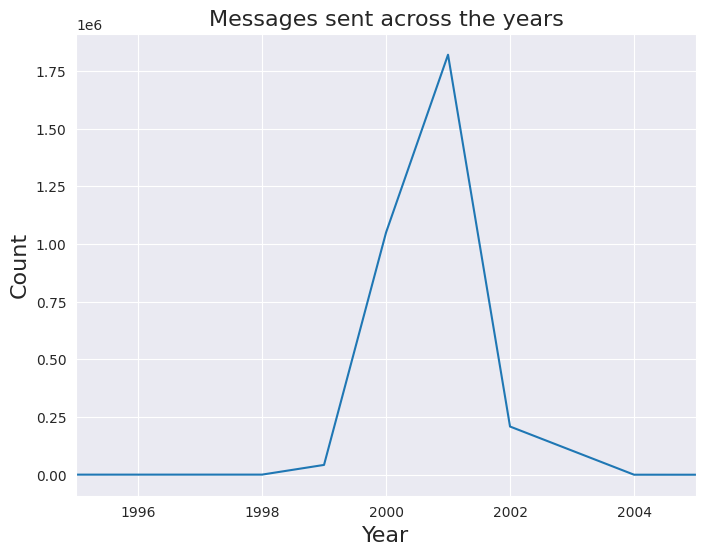

In [ ]:
ax = df.groupby(df.Year)['X-Origin'].count().plot(figsize = (8,6))
ax.set_xlim(1995,2005)
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
ax.set_title('Messages sent across the years', fontsize = 16)
plt.show()

<ipython-input-19-061525461aa3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = df['From'].value_counts().values[:30], y = df['From'].value_counts().keys()[:30] ,palette = 'rocket', orient = 'h')


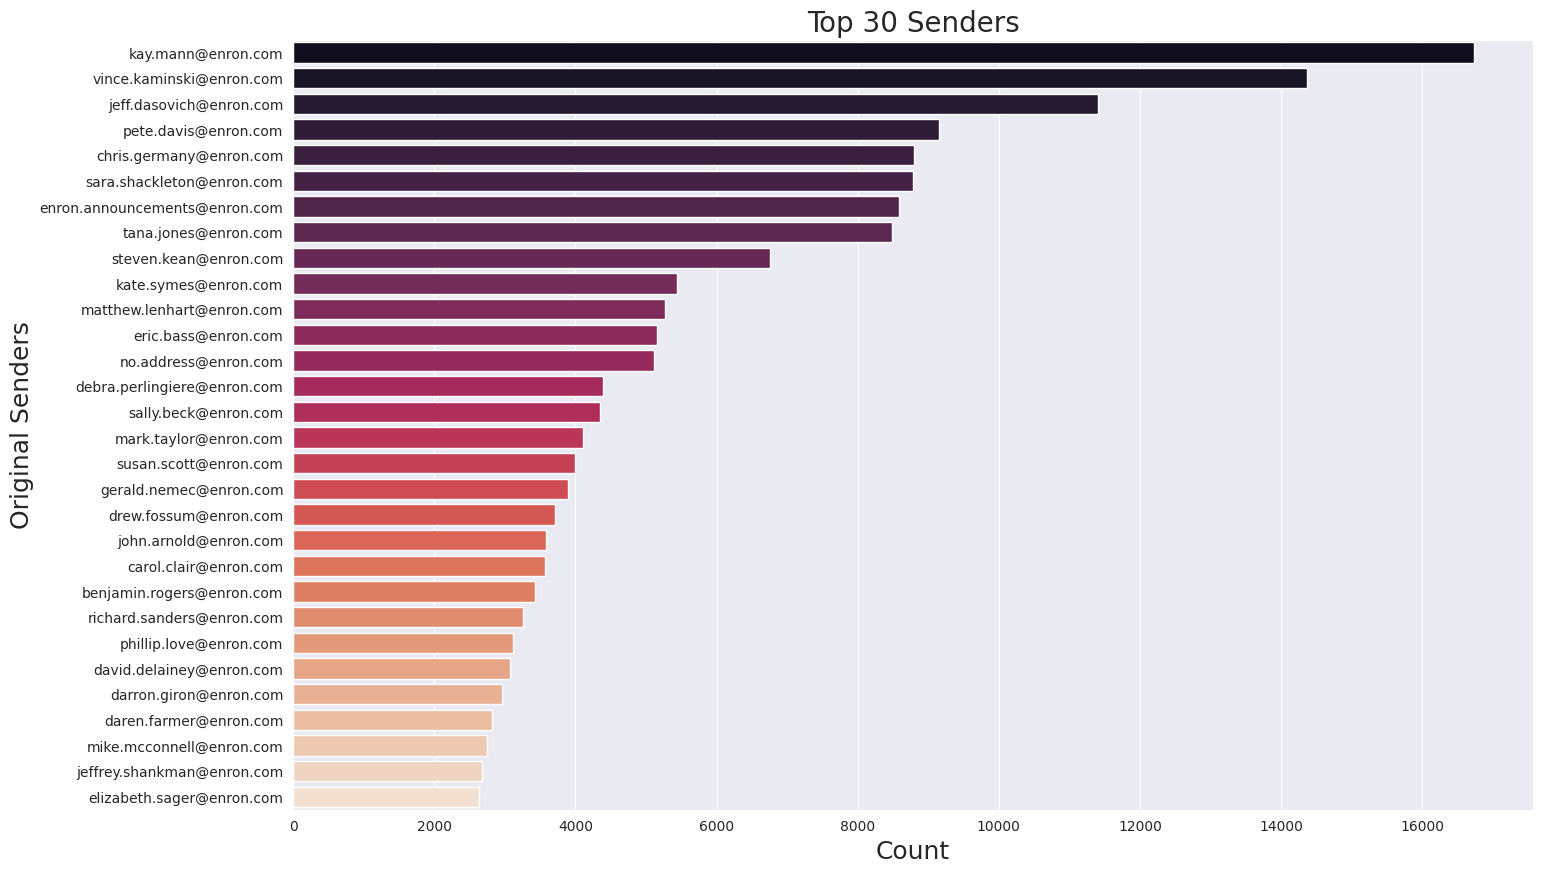

In [ ]:
# diagram for showing top senders
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['From'].value_counts().values[:30], y = df['From'].value_counts().keys()[:30] ,palette = 'rocket', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Original Senders', fontsize = 18)
ax.set_title('Top 30 Senders', fontsize = 20)
plt.show()

In [ ]:
filtered_df = df.copy()
filtered_df.dropna(subset=['To'], inplace=True)

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495554 entries, 0 to 517400
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Message-ID                 495554 non-null  object        
 1   Date                       495554 non-null  datetime64[ns]
 2   From                       495554 non-null  object        
 3   To                         495554 non-null  object        
 4   Subject                    476732 non-null  object        
 5   Mime-Version               495547 non-null  float64       
 6   Content-Type               495547 non-null  object        
 7   Content-Transfer-Encoding  495547 non-null  object        
 8   X-cc                       127172 non-null  object        
 9   X-bcc                      168 non-null     object        
 10  X-Folder                   495547 non-null  object        
 11  X-Origin                   495547 non-null  object       

In [ ]:
filtered_df['To'] = filtered_df['To'].apply(clean_emails)

In [ ]:
df3 = df.copy()
# Split receiver cell to handle multiple email addresses
df3['To'] = df3['To'].str.split(',')

# Create rows for each receiver email address
df3 = df3.explode('To')
all_emails = df['To'].str.split(',').explode().str.strip()
top_30 = all_emails.value_counts().nlargest(30)
df3 = pd.Series.to_frame(top_30)
df3['To'] = df3.indexdf3.info()

<ipython-input-57-483d20882ce3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = df3['count'], y = df3['To'],palette = 'viridis', orient = 'h')


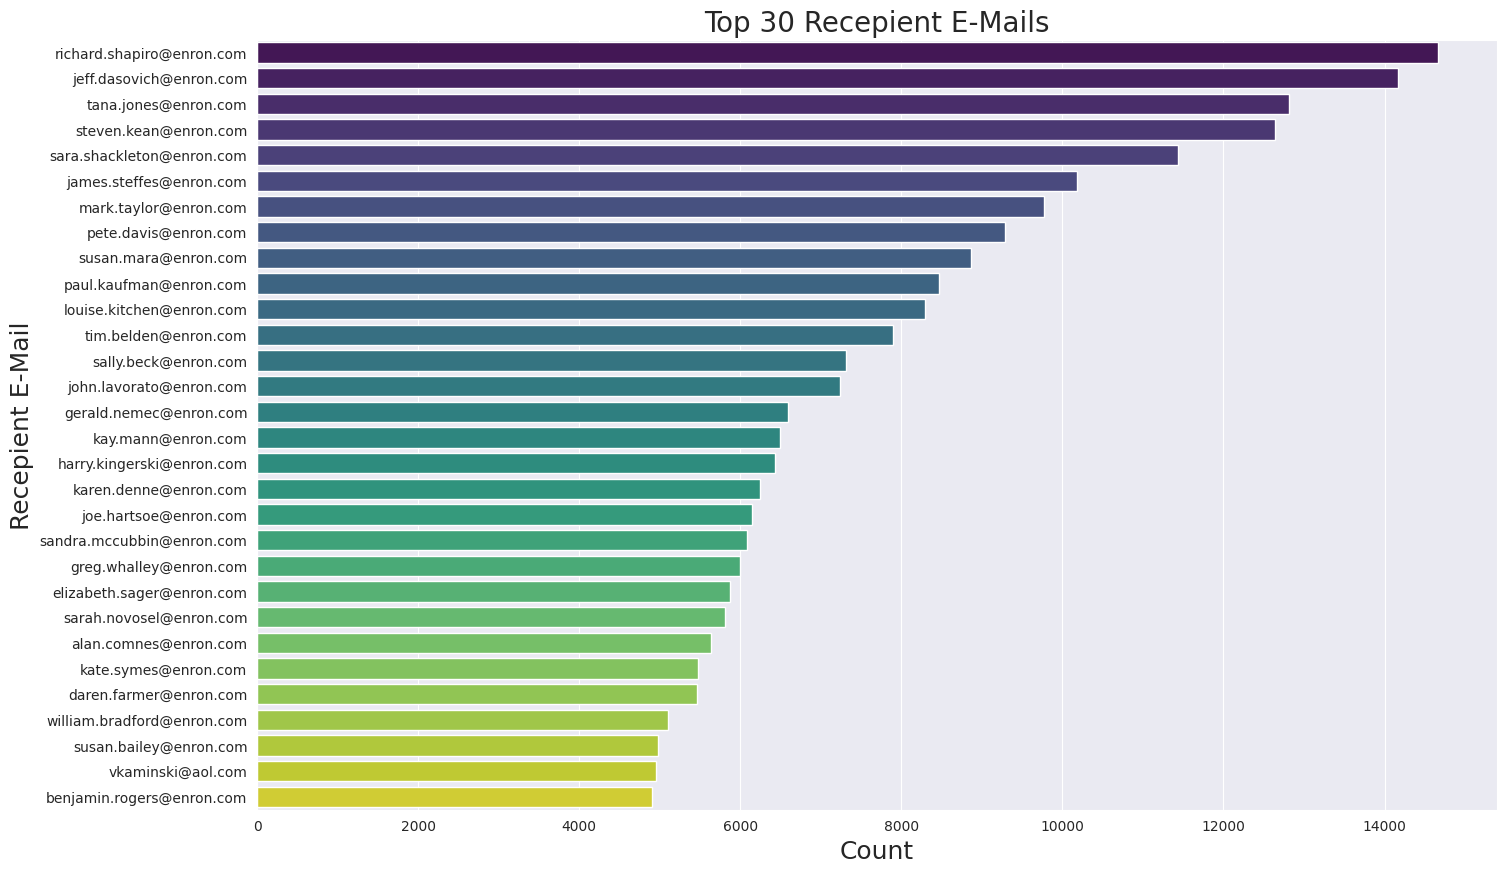

In [ ]:
# diagram showing top recepients
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df3['count'], y = df3['To'],palette = 'viridis', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Recepient E-Mail', fontsize = 18)
ax.set_title('Top 30 Recepient E-Mails', fontsize = 20)
plt.show()

In [ ]:
def extract_recipients(received):
  return received.split(', ')

In [ ]:
df['Year'].isna().sum()

0

In [ ]:
df.dropna(subset=['X-Origin'], how='all', inplace=True)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
newstopwords = ['Re', 'FW', 'Fwd', 'EOL', 'E', 'mail', 'PLEASE', 'Ahead','enron','ECT','com','www','HOU','3D','Date','Hour','ahead','said','cc','subject','thank','time','would','should','PM']
for i in newstopwords:
    stopwords.append(i)

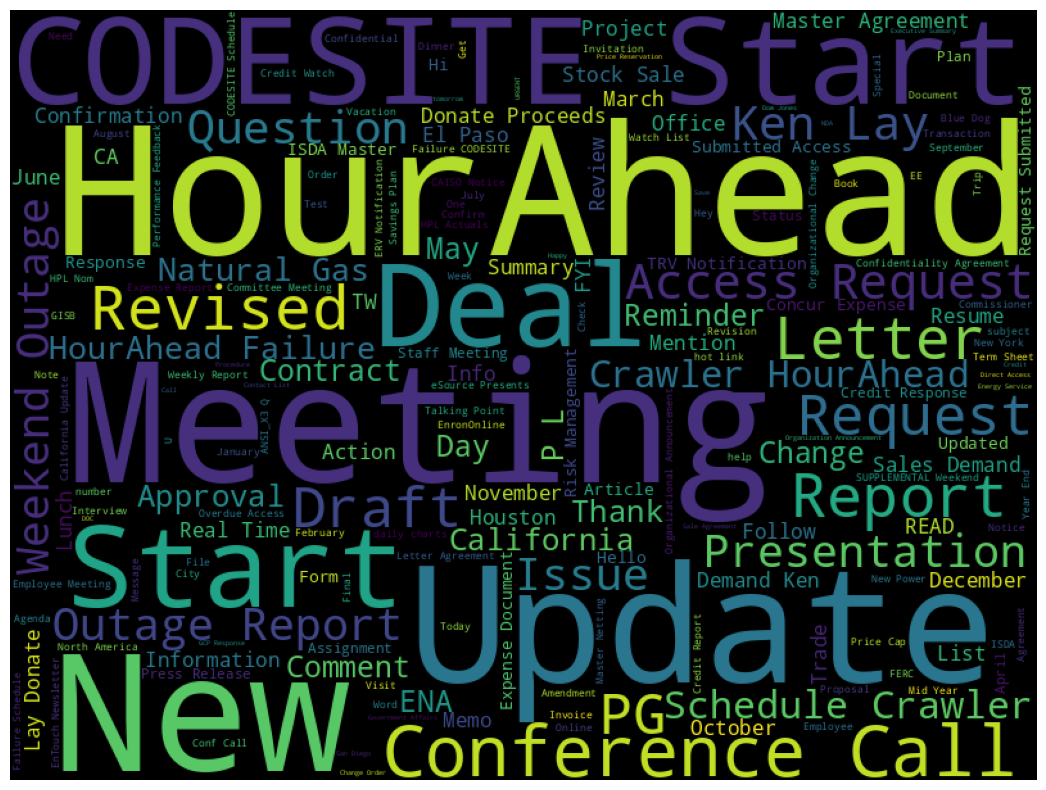

In [ ]:
df['Subject'].fillna('', inplace=True)
subjects = ' '.join(df['Subject'].values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 200, stopwords = stopwords).generate(subjects)
ax.imshow(wc)
plt.axis('off')
plt.show()

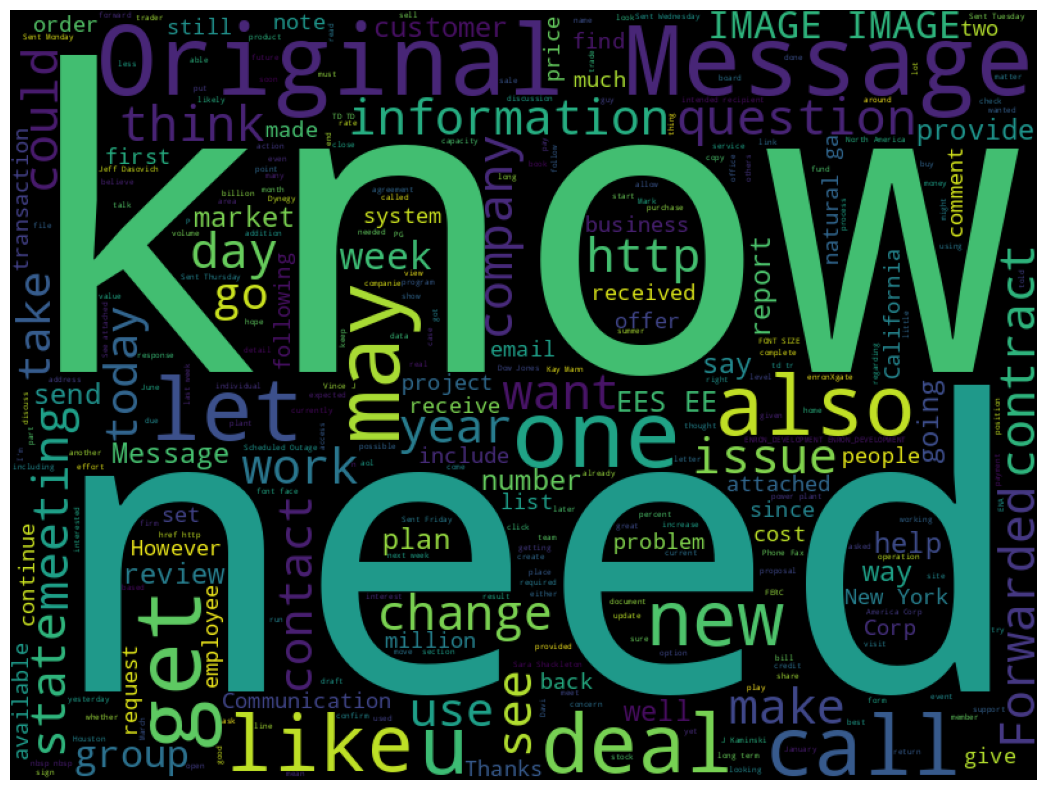

In [ ]:
content = ' '.join(df['content'].sample(50000).values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 300, stopwords = stopwords).generate(content)
ax.imshow(wc)
plt.axis('off')
plt.show()

## Performing Sentiment analyis for month of december 2001

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# preparing the lemmatization function
lemmatizer = WordNetLemmatizer()

## **Filtering Dataframe for october 2001 emails**

In [ ]:
#filtered_df = df[ (df['Date'].dt.year ==2001) & (df['Date'].dt.month ==10) ]
filtered_df = df[(df['Date'].dt.year ==2001) & (df['Date'].dt.month ==11) ]
#2001-10-26

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28607 entries, 1416 to 517400
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 28607 non-null  int64         
 1   Message-ID                 28607 non-null  object        
 2   Date                       28607 non-null  datetime64[ns]
 3   From                       28607 non-null  object        
 4   To                         26800 non-null  object        
 5   Subject                    27618 non-null  object        
 6   Mime-Version               28603 non-null  float64       
 7   Content-Type               28603 non-null  object        
 8   Content-Transfer-Encoding  28603 non-null  object        
 9   X-cc                       5255 non-null   object        
 10  X-bcc                      25 non-null     object        
 11  X-Folder                   28603 non-null  object        
 12  X-Ori

In [ ]:
text = []
for msg in filtered_df['content'].values:
    msg_tokens = word_tokenize(msg)
    msg_tokens = [token.lower() for token in msg_tokens if token.isalpha()]
    msg_tokens = [word for word in msg_tokens if not word in stopwords]
    msg_tokens = [lemmatizer.lemmatize(word) for word in msg_tokens]

    text.append(msg_tokens)

In [ ]:
text = [' '.join(message) for message in text]

In [ ]:
# vectorizing the data using Tfidfvectorizer
vectorizer = TfidfVectorizer(min_df = 5, max_features = 5000, stop_words = stopwords, norm = 'l1')
data = vectorizer.fit_transform(text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ahead', 'eol', 'fw', 'fwd', 'please'] not in stop_words.
  warnings.warn(


In [ ]:
# Normalizing the data
data_norm = normalize(data)

In [ ]:
# Decomposition of the data and decreasing alot of features
svd = TruncatedSVD(n_components = 2, n_iter = 10, random_state = 42)
datasvd = svd.fit_transform(data_norm)

In [ ]:
# Use the Elbow method to define the optimal number of clusters for kmeans clustering
max_iter = 1000
sumsquares = []
number_clusters = range(1,11)
for i in number_clusters:
    kmeans = KMeans(n_clusters = i, max_iter = max_iter, n_init = 'auto')
    kmeans.fit(datasvd)
    sumsquares.append(kmeans.inertia_)
plt.figure(figsize = (8,6))
plt.plot(number_clusters, sumsquares)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Sum of Squared Distances', fontsize = 14)
plt.title('Elbow Method', fontsize = 16)
plt.show()

In [ ]:
n_clusters = 6
clf = KMeans(n_clusters = n_clusters,init = 'random', max_iter = max_iter, tol = 0.0001, algorithm = 'lloyd', n_init = 'auto', random_state = 42)
fittedkmeans = clf.fit_predict(datasvd)
centroids = clf.cluster_centers_

In [ ]:
# A diagram showing the clusters
plt.figure(figsize = (8,6))
plt.scatter(datasvd[:,0], datasvd[:,1], c = fittedkmeans, s = 50, cmap = 'viridis', alpha = 0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], s = 150, c = 'black', alpha = 0.8)
plt.annotate('Cluster 0', xy = (centroids[0][0], centroids[0][1]), xytext = (centroids[0][0] + 0.02, centroids[0][1] + 0.03), color = 'white', fontsize = 12)
plt.annotate('Cluster 1', xy = (centroids[1][0], centroids[1][1]), xytext = (centroids[1][0] + 0.02, centroids[1][1] + 0.02), color = 'white', fontsize = 12)
plt.annotate('Cluster 2', xy = (centroids[2][0], centroids[2][1]), xytext = (centroids[2][0] - 0.05, centroids[2][1] - 0.06), color = 'white', fontsize = 12)
plt.annotate('Cluster 3', xy = (centroids[3][0], centroids[3][1]), xytext = (centroids[3][0] - 0.01, centroids[3][1] - 0.07), color = 'white', fontsize = 12)
plt.annotate('Cluster 4', xy = (centroids[4][0], centroids[4][1]), xytext = (centroids[4][0] - 0.03, centroids[4][1] + 0.04), color = 'white', fontsize = 12)
plt.annotate('Cluster 5', xy = (centroids[5][0], centroids[5][1]), xytext = (centroids[5][0] - 0.03, centroids[5][1] + 0.03), color = 'white', fontsize = 12)

plt.show()

In [ ]:
# extract top words in every cluster using the inverse_transform method
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1] #(10,5000)
terms = vectorizer.get_feature_names_out()

for i in range(n_clusters):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")

    print()

In [ ]:
filtered_df = df[(df['Year']==2001)].copy()


In [ ]:
filtered_df = filtered_df[filtered_df['content'].str.contains("skilling")]

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272935 entries, 0 to 517400
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Unnamed: 0                 272935 non-null  int64              
 1   Message-ID                 272935 non-null  object             
 2   Date                       272935 non-null  datetime64[ns, UTC]
 3   From                       272935 non-null  object             
 4   To                         256402 non-null  object             
 5   Subject                    272935 non-null  object             
 6   Mime-Version               272935 non-null  float64            
 7   Content-Type               272935 non-null  object             
 8   Content-Transfer-Encoding  272935 non-null  object             
 9   X-cc                       64421 non-null   object             
 10  X-bcc                      153 non-null     object      

In [ ]:
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


# **Sentiment Analysis Main**

In [ ]:
# praeparing the sentiment analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
newstopwords = ['Re', 'FW', 'Fwd', 'EOL', 'E', 'mail', 'PLEASE', 'Ahead']
for i in newstopwords:
    stopwords.append(i)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Removing punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [ ]:
import nltk
from nltk.corpus import stopwords
import string

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Split receiver cell to handle multiple email addresses
df['To'] = df['To'].str.split(',')

# Create rows for each receiver email address
df = df.explode('To')

In [ ]:
filtered_df1 = df[(df['From']=='kenneth.lay@enron.com') | (df['To'] == 'kenneth.lay@enron.com')]
filtered_df2 = df[(df['From']=='jeff.skilling@enron.com') | (df['To'] == 'jeff.skilling@enron.com')]
filtered_df3 = df[(df['From']=='andrew.fastow@enron.com') | (df['To'] == 'andrew.fastow@enron.com')]

In [ ]:
filtered_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6523 entries, 20638 to 503475
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Message-ID                 6523 non-null   object        
 1   Date                       6523 non-null   datetime64[ns]
 2   From                       6523 non-null   object        
 3   To                         6523 non-null   object        
 4   Subject                    6439 non-null   object        
 5   Mime-Version               6523 non-null   float64       
 6   Content-Type               6523 non-null   object        
 7   Content-Transfer-Encoding  6523 non-null   object        
 8   X-cc                       796 non-null    object        
 9   X-bcc                      26 non-null     object        
 10  X-Folder                   6523 non-null   object        
 11  X-Origin                   6523 non-null   object        
 12  X-Fil

In [ ]:
filtered_df1['clean_content'] = filtered_df1['content'].apply(preprocess_text)
filtered_df2['clean_content'] = filtered_df3['content'].apply(preprocess_text)
filtered_df3['clean_content'] = filtered_df3['content'].apply(preprocess_text)


<ipython-input-70-ee58136e8bb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df1['clean_content'] = filtered_df1['content'].apply(preprocess_text)
<ipython-input-70-ee58136e8bb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['clean_content'] = filtered_df3['content'].apply(preprocess_text)
<ipython-input-70-ee58136e8bb9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [ ]:
# Perform sentiment analysis on cleaned content
filtered_df1['sentiment_score'] = filtered_df1['clean_content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
# Perform sentiment analysis on cleaned content
#filtered_df2['sentiment_score'] = filtered_df2['clean_content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
# Perform sentiment analysis on cleaned content
filtered_df3['sentiment_score'] = filtered_df3['clean_content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

<ipython-input-72-32468282b2c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df1['sentiment_score'] = filtered_df1['clean_content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
<ipython-input-72-32468282b2c8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df3['sentiment_score'] = filtered_df3['clean_content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


In [ ]:
#kenneth.lay@enron.com
df_daily_sentiment = filtered_df1.groupby(filtered_df1['Date'].dt.date)['sentiment_score'].mean().reset_index()

In [ ]:
#jeff.skilling@enron.com
df_daily_sentiment2 = filtered_df2.groupby(filtered_df2['Date'].dt.date)['sentiment_score'].mean().reset_index()

KeyError: 'Column not found: sentiment_score'

In [ ]:
#andrew.fastow@enron.com
df_daily_sentiment3 = filtered_df3.groupby(filtered_df3['Date'].dt.date)['sentiment_score'].mean().reset_index()

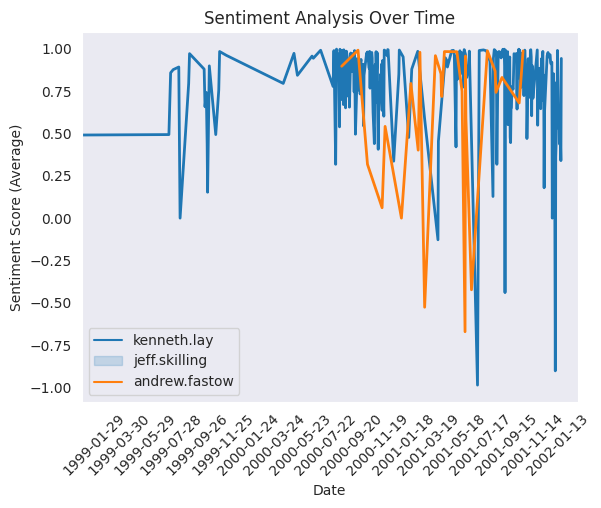

In [ ]:
# Plot sentiment over time
#plt.figure(figsize=(10, 6))
sns.lineplot(x=df_daily_sentiment['Date'], y=df_daily_sentiment['sentiment_score'])
#sns.lineplot(x=df_daily_sentiment2['Date'],y=df_daily_sentiment2['sentiment_score'])
sns.lineplot(x=df_daily_sentiment3['Date'],y=df_daily_sentiment3['sentiment_score'])
plt.title('Sentiment Analysis Over Time')
plt.legend(labels=['kenneth.lay', 'jeff.skilling', 'andrew.fastow'])
plt.xlabel('Date')
plt.ylabel('Sentiment Score (Average)')
plt.xlim(pd.Timestamp('1999-01-01'), pd.Timestamp('2002-02-28'))
plt.xticks(rotation=45)
plt.setp(plt.gca().get_lines(), linewidth=2)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.grid(False)
#plt.tight_layout()
plt.show()

# **Time Series Analysis**

## Identify trends in email activity, such as peak times or days of the week with the highest email traffic.

In [ ]:
filtered_df = df[ (df['Date'].dt.year ==2001)]

In [ ]:
# Extract hour of the day and day of the week from 'Timestamp'
filtered_df['Hour'] = filtered_df['Date'].dt.hour
filtered_df['Day_of_week'] = filtered_df['Date'].dt.dayofweek

# Group by hour of the day and calculate average email traffic
hourly_traffic = filtered_df.groupby('Hour').size()

# Group by day of the week and calculate average email traffic
daily_traffic = filtered_df.groupby('Day_of_week').size()

<ipython-input-169-31c9bbdc2c68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Hour'] = filtered_df['Date'].dt.hour
<ipython-input-169-31c9bbdc2c68>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Day_of_week'] = filtered_df['Date'].dt.dayofweek


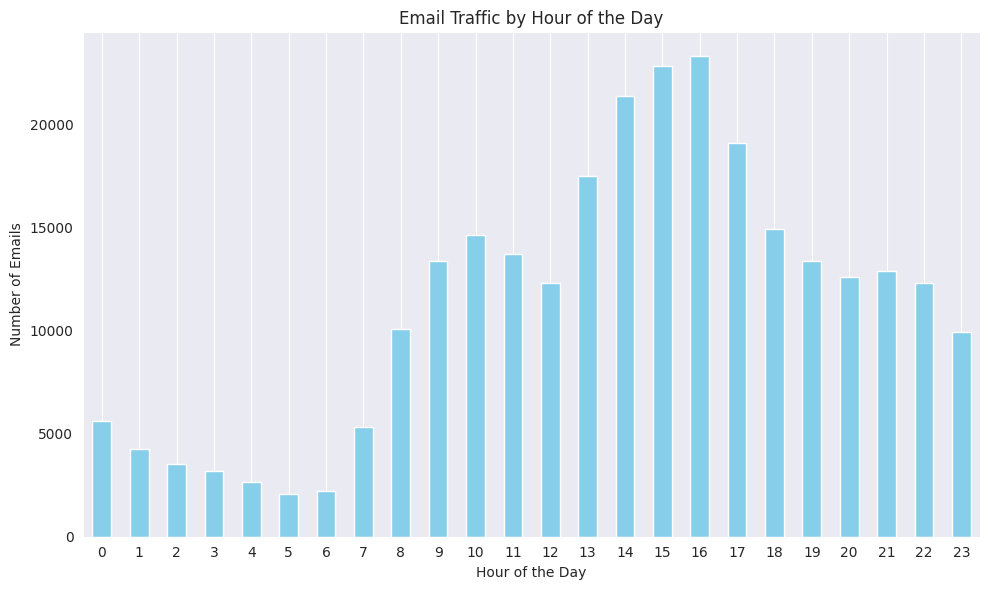

In [ ]:
# Plotting peak times by hour
plt.figure(figsize=(10, 6))
hourly_traffic.plot(kind='bar', color='skyblue')
plt.title('Email Traffic by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Emails')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


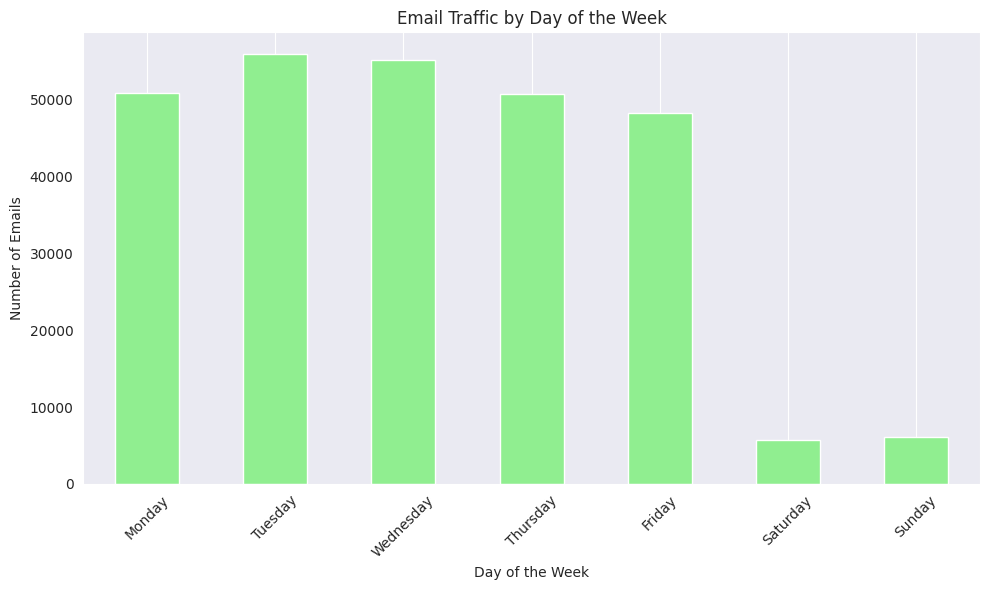

In [ ]:
# Plotting peak days of the week
# Plotting peak days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 6))
daily_traffic.index = daily_traffic.index.map(lambda x: days[x])
daily_traffic.plot(kind='bar', color='lightgreen')
plt.title('Email Traffic by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Emails')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# **LTSM**

In [ ]:
frequency_df = df.groupby('Date_yyyy_mm_dd').size().reset_index(name='email_frequency')
frequency_df.sort_values(by='email_frequency', ascending=False).head(20)

Date_yyyy_mm_dd  email_frequency
770       2000-12-13             3452
769       2000-12-12             3053
1087      2001-10-26             2943
1086      2001-10-25             2796
1111      2001-11-19             2724
1119      2001-11-27             2637
1085      2001-10-24             2593
768       2000-12-11             2536
1083      2001-10-22             2532
1084      2001-10-23             2490
1118      2001-11-26             2430
1090      2001-10-29             2426
1079      2001-10-18             2392
1112      2001-11-20             2329
1183      2002-01-30             2327
761       2000-12-04             2319
1113      2001-11-21             2210
755       2000-11-28             2147
763       2000-12-06             2122
909       2001-05-01             2109

In [ ]:
highest_freqency_days = frequency_df.sort_values(by='email_frequency', ascending=False).head(20)['Date_yyyy_mm_dd'].to_list()

In [ ]:
highest_freqency_days

[datetime.date(2000, 12, 13),
 datetime.date(2000, 12, 12),
 datetime.date(2001, 10, 26),
 datetime.date(2001, 10, 25),
 datetime.date(2001, 11, 19),
 datetime.date(2001, 11, 27),
 datetime.date(2001, 10, 24),
 datetime.date(2000, 12, 11),
 datetime.date(2001, 10, 22),
 datetime.date(2001, 10, 23),
 datetime.date(2001, 11, 26),
 datetime.date(2001, 10, 29),
 datetime.date(2001, 10, 18),
 datetime.date(2001, 11, 20),
 datetime.date(2002, 1, 30),
 datetime.date(2000, 12, 4),
 datetime.date(2001, 11, 21),
 datetime.date(2000, 11, 28),
 datetime.date(2000, 12, 6),
 datetime.date(2001, 5, 1)]

<Axes: xlabel='Date_yyyy_mm_dd', ylabel='email_frequency'>

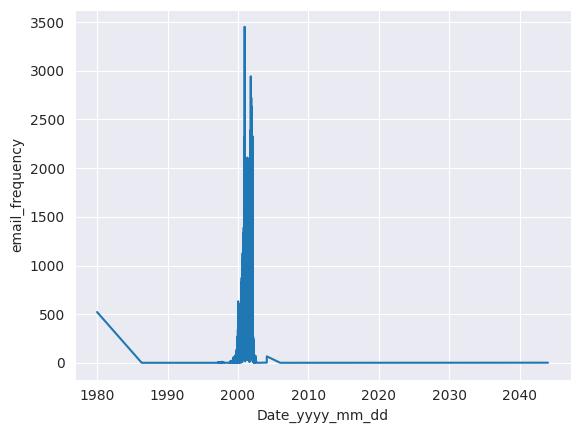

In [ ]:
sns.lineplot(x=frequency_df['Date_yyyy_mm_dd'],y=frequency_df['email_frequency'])

<Figure size 1400x500 with 0 Axes>

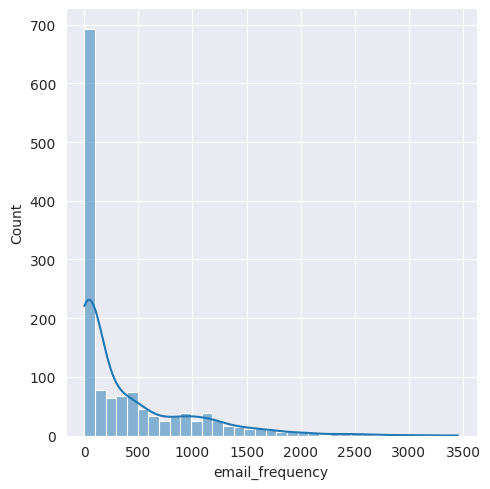

In [ ]:
plt.figure(figsize = (14,5))
sns.displot(frequency_df['email_frequency'], kde=True)

<ipython-input-177-ad5910eb31c8>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_boxcox['email_frequency_boxcox'])


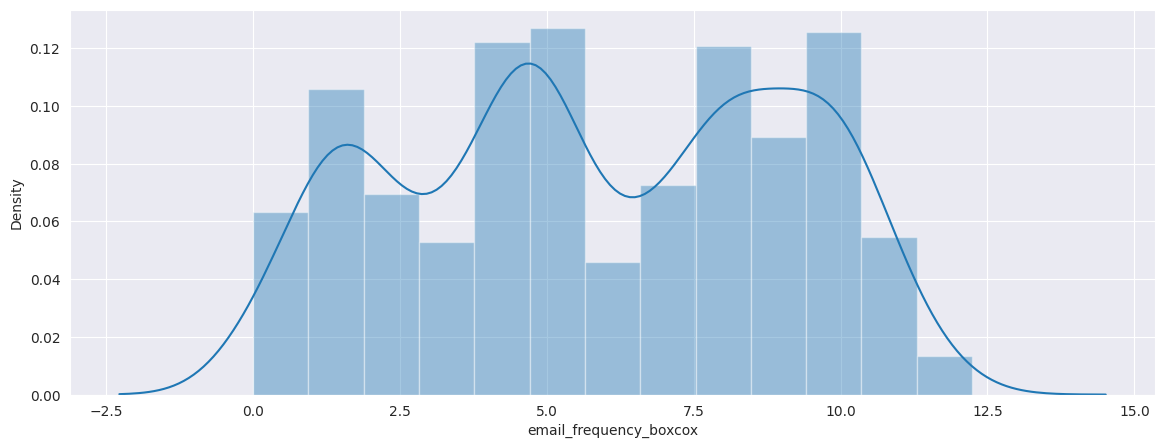

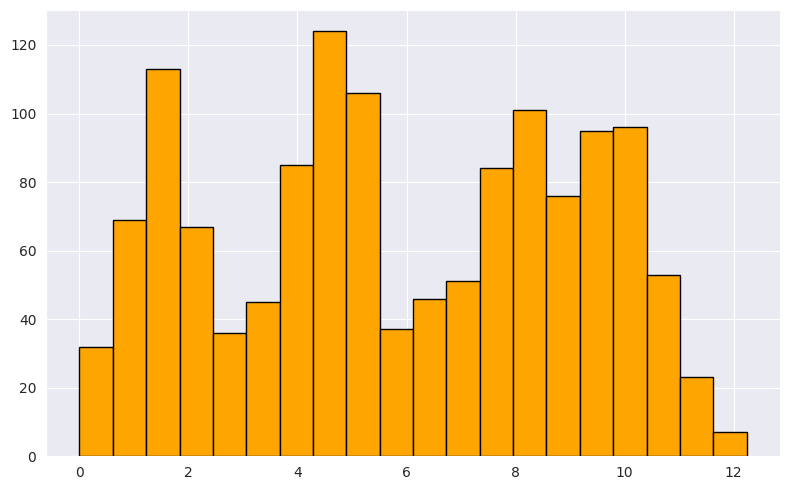

In [ ]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
df_boxcox = frequency_df.copy()

# BoxCox transformation
df_boxcox_vals, fitted_lambda = boxcox(df_boxcox['email_frequency'])

df_boxcox['email_frequency_boxcox'] = df_boxcox_vals


# dist plot
plt.figure(figsize = (14,5))
sns.distplot(df_boxcox['email_frequency_boxcox'])

# Histogram
fig, axs = plt.subplots(1, 1,figsize =(8, 5),tight_layout = True)
axs.hist(df_boxcox['email_frequency_boxcox'], bins = 20, color = 'orange',edgecolor='black')
plt.show()

In [ ]:
from scipy.stats import shapiro

stat, pval = shapiro(frequency_df['email_frequency'])

In [ ]:
df_boxcox.drop('email_frequency',axis=1,inplace=True)
frequency_df = df_boxcox
frequency_df

Date_yyyy_mm_dd  email_frequency_boxcox
0         1980-01-01                8.517952
1         1986-04-26                0.000000
2         1986-05-01                0.000000
3         1997-01-01                0.000000
4         1997-03-03                1.157321
...              ...                     ...
1341      2020-12-29                0.000000
1342      2024-05-26                0.000000
1343      2043-12-28                0.000000
1344      2044-01-02                0.000000
1345      2044-01-04                0.716218

[1346 rows x 2 columns]

In [ ]:
def Sequential_Input_LSTM(df, input_sequence):
    df_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        label = df_np[i + input_sequence]
        y.append(label)

    return np.array(X), np.array(y)


n_input = 10

df_min_model_data = frequency_df['email_frequency_boxcox']

X, y = Sequential_Input_LSTM(df_min_model_data, n_input)

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
# Training data
X_train, y_train = X[:1134], y[:1134]

# Validation data
X_val, y_val = X[1134:1234], y[1134:1234]

# Test data
X_test, y_test = X[1234:], y[1234:]

In [ ]:
n_features = 1

model1 = Sequential()

model1.add(InputLayer((n_input,n_features)))
model1.add(LSTM(50))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dense(1, activation = 'linear'))

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

model1.compile(loss = MeanSquaredError(),
               optimizer = Adam(learning_rate = 0.0001),
               metrics = RootMeanSquaredError())

model1.fit(X_train, y_train,
           validation_data = (X_val, y_val),
           epochs = 100,
           callbacks = [early_stop])

Epoch 1/100
36/36 [==============================] - 7s 49ms/step - loss: 43.7229 - root_mean_squared_error: 6.6123 - val_loss: 45.0791 - val_root_mean_squared_error: 6.7141
Epoch 2/100
36/36 [==============================] - 1s 19ms/step - loss: 39.9205 - root_mean_squared_error: 6.3183 - val_loss: 40.9267 - val_root_mean_squared_error: 6.3974
Epoch 3/100
36/36 [==============================] - 1s 17ms/step - loss: 36.7239 - root_mean_squared_error: 6.0600 - val_loss: 37.5241 - val_root_mean_squared_error: 6.1257
Epoch 4/100
36/36 [==============================] - 1s 16ms/step - loss: 33.6686 - root_mean_squared_error: 5.8025 - val_loss: 33.8424 - val_root_mean_squared_error: 5.8174
Epoch 5/100
36/36 [==============================] - 0s 13ms/step - loss: 30.2680 - root_mean_squared_error: 5.5016 - val_loss: 29.6729 - val_root_mean_squared_error: 5.4473
Epoch 6/100
36/36 [==============================] - 0s 13ms/step - loss: 26.4179 - root_mean_squared_error: 5.1398 - val_loss: 24

In [ ]:
y_pred = model1.predict(X_test).flatten()


X_test_list = []
for i in range(len(X_test)):
    X_test_list.append(X_test[i][0])


test_predictions_df1 = pd.DataFrame({'X_test':list(X_test_list),
                                    'LSTM Prediction':list(y_pred)})

4/4 [==============================] - 1s 9ms/step


In [ ]:
test_predictions1 = model1.predict(X_test)

4/4 [==============================] - 0s 7ms/step


In [ ]:
test_predictions_df1

X_test  LSTM Prediction
0    6.207818         4.619864
1    2.689529         5.577774
2    2.995087         5.102738
3    7.068536         4.447264
4    5.324775         3.912986
..        ...              ...
97   0.000000         0.753658
98   0.000000         0.490771
99   0.000000         0.252467
100  1.157321         0.052453
101  5.156436        -0.009509

[102 rows x 2 columns]

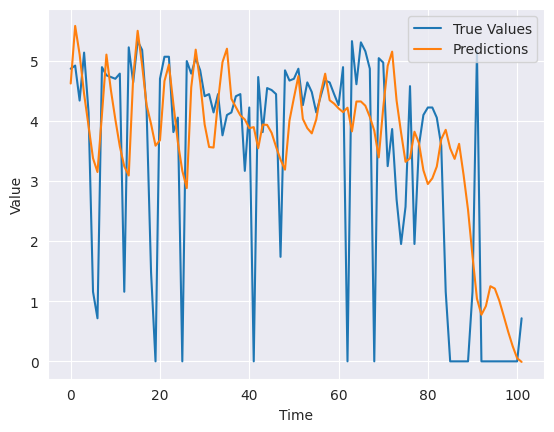

In [ ]:
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
mean_squared_error(y_test, test_predictions1)

2.312367863570951

In [ ]:
mean_absolute_error(y_test,test_predictions1)

1.0927231322395774

#  Identify frequently mentioned keywords or phrases to gain insights into the most common subjects of communication within the organization.

In [ ]:
filtered_df = df[(df['Date'].dt.year ==2001) & (df['Date'].dt.month.isin([8,9,10,11,12]))]

<ipython-input-27-caf97a24a191>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Subject'] = filtered_df['Subject'].fillna('')


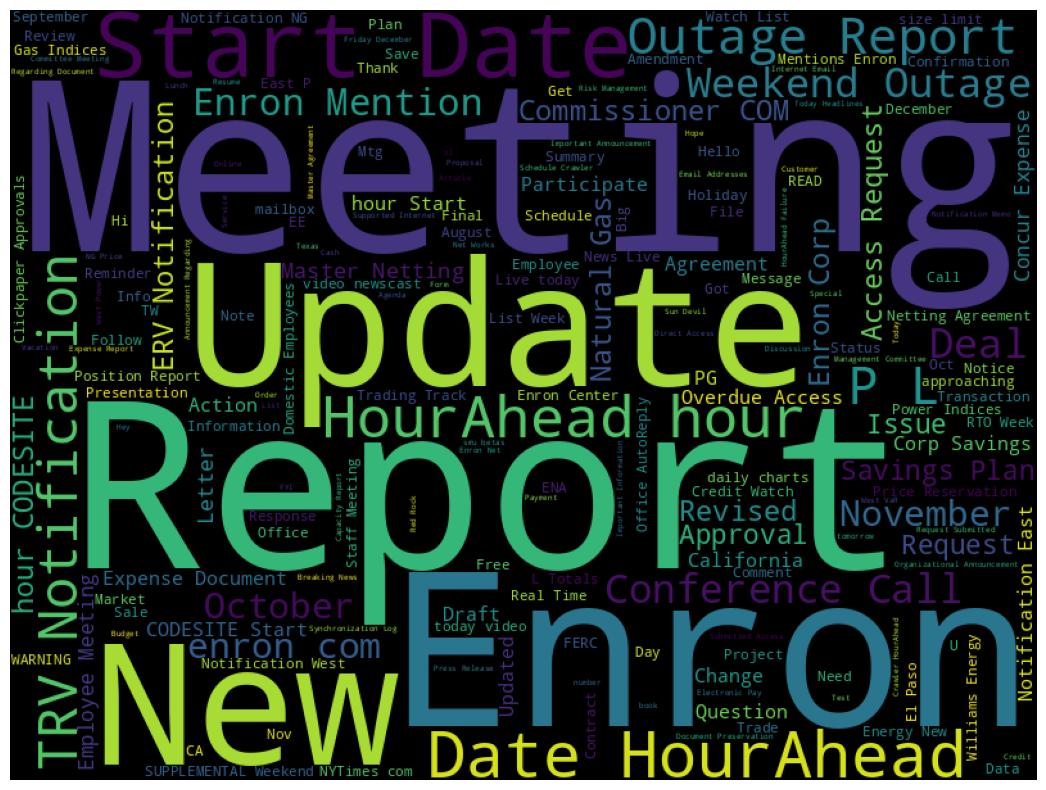

In [ ]:
filtered_df['Subject'] = filtered_df['Subject'].fillna('')
subjects = ' '.join(filtered_df['Subject'].values)
fig, ax = plt.subplots(figsize=(14, 10))
wc = wordcloud.WordCloud(width = 800, height = 600, max_words = 200, stopwords = stopwords).generate(subjects)
ax.imshow(wc)
plt.axis('off')
plt.show()

### **NLP**



# After you identified employees who are the most frequent senders and receivers of emails, explore the content and context of emails sent by top senders to understand their roles and responsibilities within the company.

In [ ]:
#NLP needed Libraries
nltk.download('wordnet')
nltk.download('punkt')
# preparing the lemmatization function
lemmatizer = WordNetLemmatizer()
# praeparing the sentiment analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
stopwords = nltk.corpus.stopwords.words('english')
newstopwords = ['Re', 'FW', 'Fwd', 'EOL', 'E', 'mail', 'PLEASE', 'Ahead']
for i in newstopwords:
    stopwords.append(i)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# list of top 20 senders Ref local notebook
top_20_senders = ["frozenset({'kay.mann@enron.com'})",
 "frozenset({'vince.kaminski@enron.com'})",
 "frozenset({'jeff.dasovich@enron.com'})",
 "frozenset({'pete.davis@enron.com'})",
 "frozenset({'chris.germany@enron.com'})",
 "frozenset({'sara.shackleton@enron.com'})",
 "frozenset({'enron.announcements@enron.com'})",
 "frozenset({'tana.jones@enron.com'})",
 "frozenset({'steven.kean@enron.com'})",
 "frozenset({'kate.symes@enron.com'})",
 "frozenset({'matthew.lenhart@enron.com'})",
 "frozenset({'eric.bass@enron.com'})",
 "frozenset({'no.address@enron.com'})",
 "frozenset({'debra.perlingiere@enron.com'})",
 "frozenset({'sally.beck@enron.com'})",
 "frozenset({'mark.taylor@enron.com'})",
 "frozenset({'susan.scott@enron.com'})",
 "frozenset({'gerald.nemec@enron.com'})",
 "frozenset({'drew.fossum@enron.com'})",
 "frozenset({'john.arnold@enron.com'})"]

In [ ]:
top_5_senders = top_20_senders[:5]

In [ ]:
top_5_receivers = ["frozenset({'pete.davis@enron.com'})","frozenset({'tana.jones@enron.com'})", "frozenset({'sara.shackleton@enron.com'})",
                    "frozenset({'vince.kaminski@enron.com'})","frozenset({'jeff.dasovich@enron.com'})","frozenset({'kate.symes@enron.com'})"]

In [ ]:
def cleaningbody(col):
    msgcol = []
    for msg in col.values:
        msg = re.sub(r'[<>\n+\t+\s+\*]', ' ', msg)
        msg = re.sub(r'[0-9]+[a-zA-Z]+\d+[?!].DOC', ' ', msg)
        msg = re.sub(r'[?\s+\-+\s+?_=~]', ' ', msg)
        msg = re.sub(r' +', ' ', msg)
        msg = msg.lower().strip(' ')
        msgcol.append(msg)
    return msgcol

In [ ]:
def perform_sentiment_analysis_for_sender(emailID,year):
  filtered_df = df[(df['From']==emailID) & (df['Date'].dt.year==year) ]
  filtered_df['content'] = cleaningbody(filtered_df['content'])
  text = []
  for msg in filtered_df['content'].values:
      msg_tokens = word_tokenize(msg)
      msg_tokens = [token.lower() for token in msg_tokens if token.isalpha()]
      msg_tokens = [word for word in msg_tokens if not word in stopwords]
      msg_tokens = [lemmatizer.lemmatize(word) for word in msg_tokens]

      text.append(msg_tokens)
  text = [' '.join(message) for message in text]
  analyzer = SentimentIntensityAnalyzer()
  filtered_df['sentiment scores'] = [analyzer.polarity_scores(message) for message in text]
  sentiment = []
  for i in filtered_df['sentiment scores'].values:
      if i['compound'] > 0.05:
          sentiment.append('Positive')
      elif i['compound'] < 0.05:
          sentiment.append('Negative')
      else:
          sentiment.append('Neutral')
  filtered_df['Sentiment'] = sentiment
  sentiment_values = filtered_df['Sentiment'].value_counts()
  return sentiment_values

In [ ]:
perform_sentiment_analysis_for_sender('kay.mann@enron.com',2001)

<ipython-input-27-bf1a5097470e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['content'] = cleaningbody(filtered_df['content'])
<ipython-input-27-bf1a5097470e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sentiment scores'] = [analyzer.polarity_scores(message) for message in text]
<ipython-input-27-bf1a5097470e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

Sentiment
Positive    7809
Negative    1104
Name: count, dtype: int64

# Which of the employees send/receive a high volume of emails related to topics such as travel/sick leave/vacation/financial matters? Can you recognize the role of those employees in the company?

In [ ]:
#leave_keywords = ['leave', 'holiday', 'vacation', 'time off', 'annual leave', 'sick leave', 'PTO']

# List of words related to Leave and
leave_keywords = [
    'leave', 'vacation', 'time off', 'holiday', 'absence',
    'annual leave', 'sick leave', 'parental leave', 'personal leave',
    'unpaid leave', 'paid time off', 'PTO', 'day off', 'time away',
    'absence request', 'leave request', 'time-off request', 'request for leave', 'travel', 'trip', 'journey', 'itinerary', 'destination',
    'flight', 'hotel', 'accommodation', 'reservation', 'booking',
    'transportation', 'airline', 'departure', 'arrival', 'check-in',
    'check-out', 'travel dates', 'travel arrangements'
]

finance_words = [
    'finance', 'financial', 'accounting', 'investment', 'investing',
    'portfolio', 'asset', 'liability', 'equity', 'balance sheet',
    'income statement', 'cash flow statement', 'financial statement',
    'budget', 'budgeting', 'forecast', 'forecasting', 'analysis',
    'financial analysis', 'risk', 'return', 'ROI', 'return on investment',
    'interest', 'rate', 'bond', 'stock', 'equities', 'dividend',
    'dividends', 'capital', 'capitalization', 'debt', 'credit',
    'loan', 'mortgage', 'interest rate', 'credit score', 'credit rating',
    'financial planning', 'financial management', 'financial market',
    'stock market', 'bull market', 'bear market', 'exchange', 'trading',
    'investor', 'trader', 'brokerage', 'fund', 'mutual fund', 'ETF',
    'exchange-traded fund', 'hedge fund', 'derivative', 'option',
    'futures', 'commodity', 'currency', 'forex', 'risk management',
    'portfolio management', 'tax', 'taxes', 'taxation', 'tax planning',
    'tax return', 'audit', 'auditing', 'financial regulation', 'regulatory compliance'
]

In [ ]:
# Fill NaN subjects with an empty string
df['Subject'].fillna('', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Message-ID                 517401 non-null  object        
 1   Date                       517401 non-null  datetime64[ns]
 2   From                       517401 non-null  object        
 3   To                         495554 non-null  object        
 4   Subject                    517401 non-null  object        
 5   Mime-Version               517372 non-null  float64       
 6   Content-Type               517372 non-null  object        
 7   Content-Transfer-Encoding  517372 non-null  object        
 8   X-cc                       128886 non-null  object        
 9   X-bcc                      175 non-null     object        
 10  X-Folder                   517372 non-null  object        
 11  X-Origin                   517372 non-null  object  

In [ ]:
leave_emails = df[df['content'].str.contains('|'.join(leave_keywords), case=False)]
receiver_count = leave_emails['To'].value_counts()

In [ ]:
receiver_count = leave_emails['To'].value_counts()

In [ ]:
receiver_count.head(11)

To
vkaminski@aol.com            809
all.houston@enron.com        793
jeff.dasovich@enron.com      754
sara.shackleton@enron.com    539
tana.jones@enron.com         458
steven.kean@enron.com        443
mark.taylor@enron.com        441
gerald.nemec@enron.com       438
all.worldwide@enron.com      416
vince.kaminski@enron.com     407
sally.beck@enron.com         405
Name: count, dtype: int64

In [ ]:
leave_emails = df[df['content'].str.contains('|'.join(finance_words), case=False)]
receiver_count2 = leave_emails['To'].value_counts()

In [ ]:
receiver_count2.head(15)

To
tana.jones@enron.com         3526
sara.shackleton@enron.com    3487
vkaminski@aol.com            2699
jeff.dasovich@enron.com      2296
all.worldwide@enron.com      2255
mark.taylor@enron.com        1952
steven.kean@enron.com        1643
vince.kaminski@enron.com     1471
louise.kitchen@enron.com     1402
klay@enron.com               1384
sally.beck@enron.com         1343
all.houston@enron.com        1341
kay.mann@enron.com           1269
richard.shapiro@enron.com    1118
pete.davis@enron.com         1103
Name: count, dtype: int64

In [ ]:
max_receiver = receiver_count.idxmax()
max_email_count = receiver_count.max()

print(f"The receiver who got the maximum emails regarding bussiness and finance: {max_receiver}")
print(f"Number of emails received: {max_email_count}")

The receiver who got the maximum emails regarding bussiness and finance: tana.jones@enron.com
Number of emails received: 3526


# Network Analysis

In [ ]:
pip install python-louvain

In [ ]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities # Louvain method for community detection
import community.community_louvain as cl
import matplotlib.pyplot as plt

In [ ]:
filtered_df = df.copy()

In [ ]:
# Split receiver cell to handle multiple email addresses
filtered_df['To'] = filtered_df['To'].str.split(',')
# Create rows for each receiver email address
filtered_df = filtered_df.explode('To')
top_20_senders = list(filtered_df['From'].value_counts()[:50].index)
top_20_receivers = list(filtered_df['To'].value_counts()[:50].index)

In [ ]:
filtered_df.dropna(subset=['To'], inplace=True)
filtered_df.drop_duplicates(inplace=True)

In [ ]:
filtered_df2 = filtered_df[filtered_df['From'].isin(top_20_senders) & filtered_df['To'].isin(top_20_receivers)]

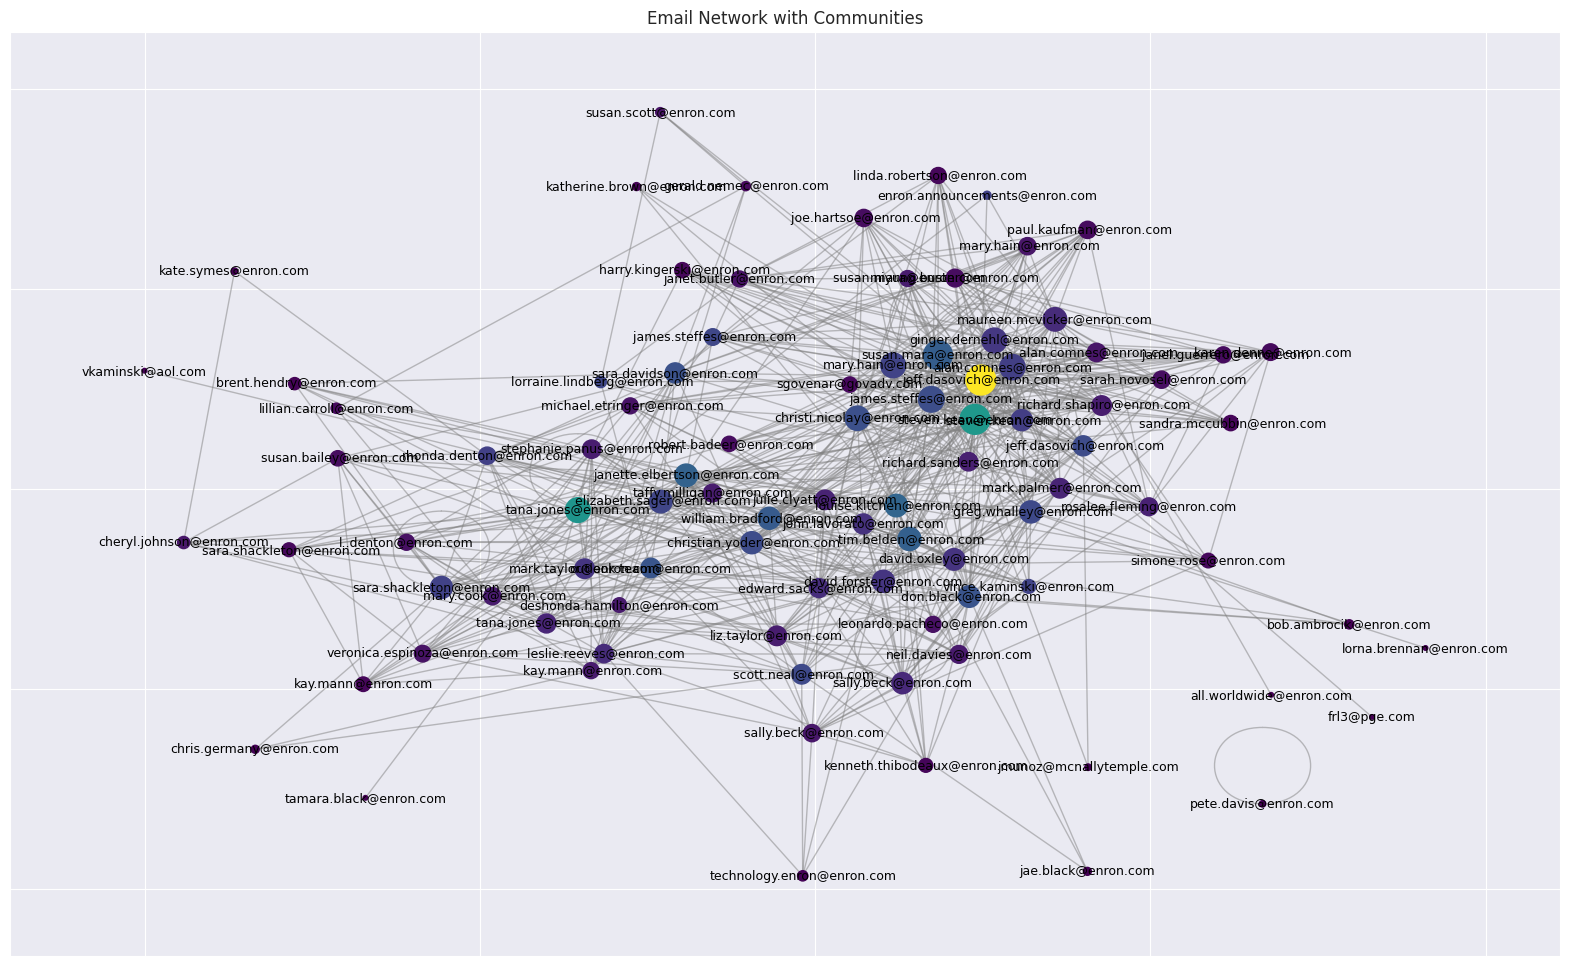

In [ ]:
G = nx.from_pandas_edgelist(filtered_df2, 'From', 'To')

# Apply community detection algorithm
partition = cl.best_partition(G)

# Add community information to nodes
for node, community_id in partition.items():
    G.nodes[node]['community'] = community_id

# Plot the network with communities
pos = nx.spring_layout(G,k=3, iterations=200)  # Layout algorithm

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
# Add more centrality measures as needed

# Node sizing based on centrality
node_size = [1000 * degree_centrality[node] for node in G.nodes()]
# Node coloring based on centrality
node_color = [betweenness_centrality[node] for node in G.nodes()]

plt.figure(figsize=(20, 12))
nx.draw_networkx_nodes(G, pos, node_size=node_size, cmap=plt.cm.viridis, node_color=node_color,label=True)
nx.draw_networkx_edges(G, pos, alpha=0.5,edge_color='grey')
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("Email Network with Communities")
plt.show()

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(G)
centralities_df = pd.DataFrame(zip(eigenvector_centrality.keys(),eigenvector_centrality.values()),columns=['Node','Eigen Centrality'])

In [ ]:
df_eigen = centralities_df.sort_values('Eigen Centrality',ascending=False).head(10)

In [ ]:
eigen_list = df_eigen['Node'].tolist()

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G)
centralities_df = pd.DataFrame(zip(betweenness_centrality.keys(),betweenness_centrality.values()),columns=['Node','Betweeness Centrality'])

In [ ]:
df_between = centralities_df.sort_values('Betweeness Centrality',ascending=False).head(10)
between_list = df_between['Node'].tolist()

In [ ]:
degree_centrality = nx.degree_centrality(G)
centralities_df = pd.DataFrame(zip(degree_centrality.keys(),degree_centrality.values()),columns=['Node','Degree Centrality'])

In [ ]:
df_degree = centralities_df.sort_values('Degree Centrality',ascending=False).head(10)

In [ ]:
degree_list = df_degree['Node'].tolist()

In [ ]:
# Find the largest community
largest_community_id = max(partition.values(), key=lambda x: list(partition.values()).count(x))
largest_community = [node for node, community_id in partition.items() if community_id == largest_community_id]

# Get the subgraph corresponding to the largest community
largest_community_subgraph = G.subgraph(largest_community)

# Analyze the largest community
largest_community_degree_centrality = nx.degree_centrality(largest_community_subgraph)
average_degree_largest_community = sum(largest_community_degree_centrality.values()) / len(largest_community_degree_centrality)

# You can perform more analysis here, such as computing betweenness centrality, clustering coefficient, etc.

# Print out the analysis results
print("Analysis of the Largest Community:")
print(f"Number of Nodes: {len(largest_community)}")
print(f"Average Degree Centrality: {average_degree_largest_community}")
# Print more analysis results as needed

Analysis of the Largest Community:
Number of Nodes: 37
Average Degree Centrality: 0.35285285285285295


In [ ]:
largest_community

['mary.hain@enron.com',
 ' susan.mara@enron.com',
 ' paul.kaufman@enron.com',
 ' sarah.novosel@enron.com',
 ' robert.badeer@enron.com',
 ' richard.shapiro@enron.com',
 ' james.steffes@enron.com',
 'jeff.dasovich@enron.com',
 ' sandra.mccubbin@enron.com',
 ' joe.hartsoe@enron.com',
 ' karen.denne@enron.com',
 'susan.mara@enron.com',
 ' mary.hain@enron.com',
 ' steven.kean@enron.com',
 ' jeff.dasovich@enron.com',
 ' janel.guerrero@enron.com',
 ' richard.sanders@enron.com',
 ' alan.comnes@enron.com',
 'christi.nicolay@enron.com',
 ' harry.kingerski@enron.com',
 ' linda.robertson@enron.com',
 ' mark.palmer@enron.com',
 'steven.kean@enron.com',
 'rosalee.fleming@enron.com',
 'janet.butler@enron.com',
 'lorna.brennan@enron.com',
 ' lorraine.lindberg@enron.com',
 'alan.comnes@enron.com',
 'ginger.dernehl@enron.com',
 'james.steffes@enron.com',
 'maureen.mcvicker@enron.com',
 'susan.scott@enron.com',
 'jmunoz@mcnallytemple.com',
 'miyung.buster@enron.com',
 'sgovenar@govadv.com',
 'frl3@pge.co

# doing analysis on nodes having highest centralities

In [ ]:
eigen_list

['steven.kean@enron.com',
 'susan.mara@enron.com',
 'jeff.dasovich@enron.com',
 'james.steffes@enron.com',
 'alan.comnes@enron.com',
 'ginger.dernehl@enron.com',
 'mary.hain@enron.com',
 'maureen.mcvicker@enron.com',
 'christi.nicolay@enron.com',
 ' tim.belden@enron.com']

In [ ]:
degree_list

['jeff.dasovich@enron.com',
 'steven.kean@enron.com',
 'susan.mara@enron.com',
 'james.steffes@enron.com',
 'alan.comnes@enron.com',
 'mary.hain@enron.com',
 'tana.jones@enron.com',
 'ginger.dernehl@enron.com',
 'christi.nicolay@enron.com',
 'maureen.mcvicker@enron.com']

In [ ]:
between_list

['jeff.dasovich@enron.com',
 'steven.kean@enron.com',
 'tana.jones@enron.com',
 ' louise.kitchen@enron.com',
 'janette.elbertson@enron.com',
 ' tim.belden@enron.com',
 'susan.mara@enron.com',
 ' william.bradford@enron.com',
 'outlook.team@enron.com',
 ' don.black@enron.com']

In [ ]:
unique_values = set(between_list) | set(degree_list) | set(eigen_list)

# Convert the result back to a list if necessary
unique_values_list = list(unique_values)

In [ ]:
len(unique_values_list)

16

In [ ]:
filtered_df4 = filtered_df[(filtered_df['From'].isin(unique_values_list)) & (filtered_df['To'].isin(unique_values_list))]

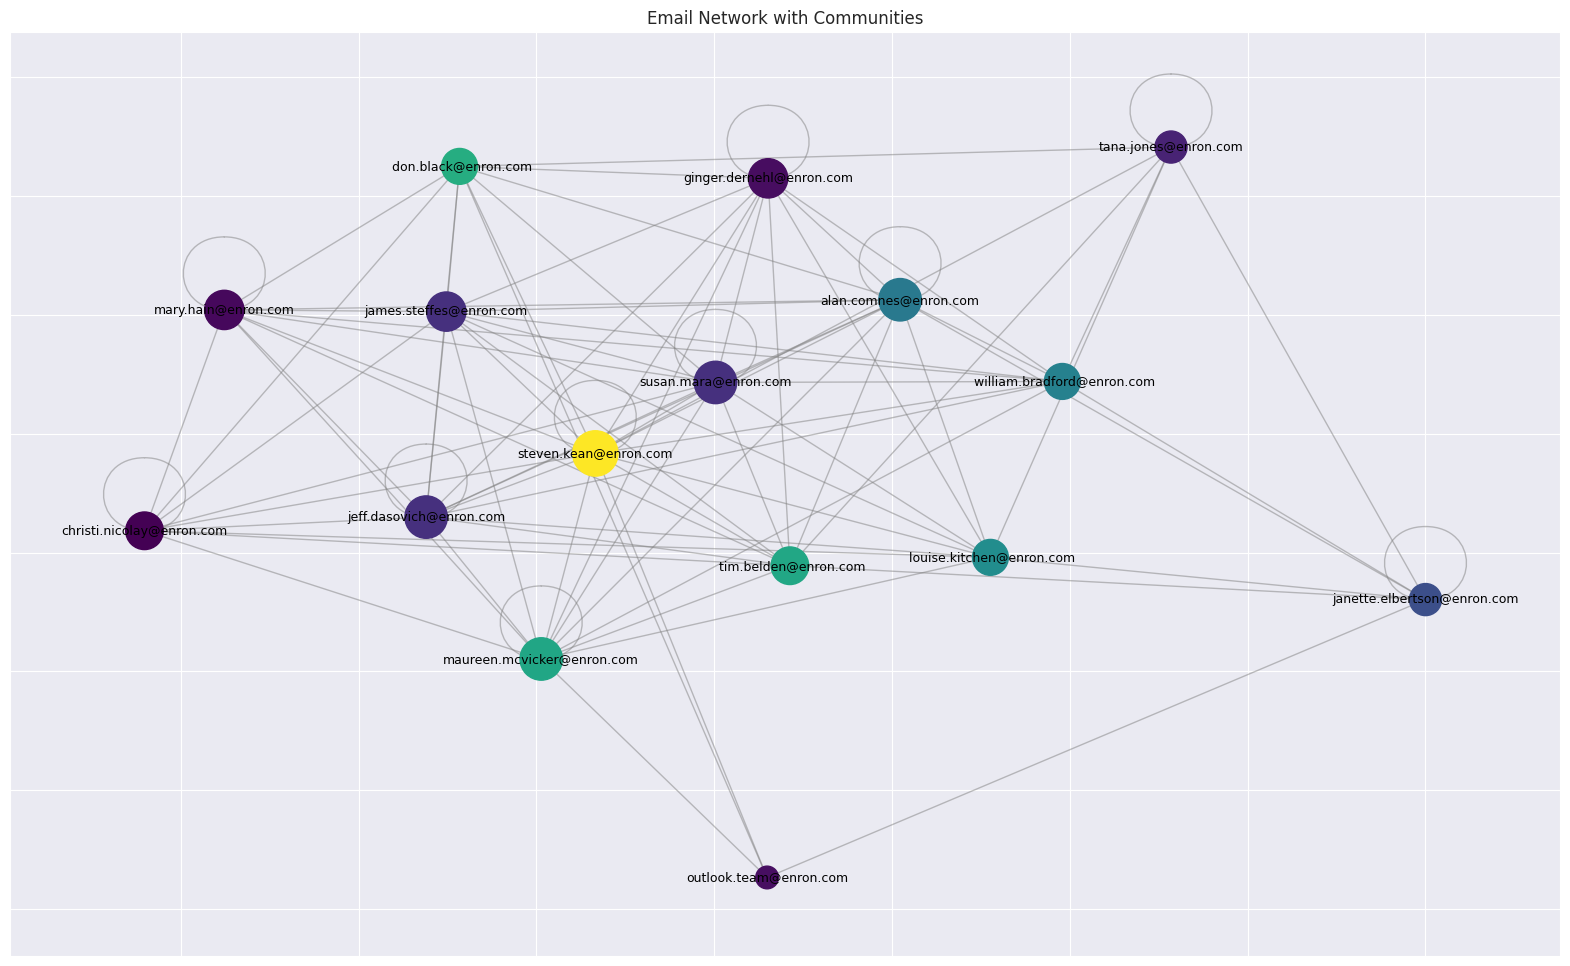

In [ ]:
G = nx.from_pandas_edgelist(filtered_df4, 'From', 'To')

# Apply community detection algorithm
partition = cl.best_partition(G)

# Add community information to nodes
for node, community_id in partition.items():
    G.nodes[node]['community'] = community_id

# Plot the network with communities
pos = nx.spring_layout(G,k=3, iterations=100)  # Layout algorithm

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
# Add more centrality measures as needed

# Node sizing based on centrality
node_size = [1000 * degree_centrality[node] for node in G.nodes()]
# Node coloring based on centrality
node_color = [betweenness_centrality[node] for node in G.nodes()]

plt.figure(figsize=(20, 12))
nx.draw_networkx_nodes(G, pos, node_size=node_size, cmap=plt.cm.viridis, node_color=node_color,label=True)
nx.draw_networkx_edges(G, pos, alpha=0.5,edge_color='grey')
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("Email Network with Communities")
plt.show()

# another network analysis

Degree Centrality Analysis:
Maximum Degree Node: jeff.dasovich@enron.com (Degree: 0.46153846153846156)
Minimum Degree Node: all.worldwide@enron.com (Degree: 0.01098901098901099)
Average Degree: 0.16411849020544667

Betweenness Centrality Analysis:
Maximum Betweenness Node: jeff.dasovich@enron.com (Betweenness: 0.11001678524667882)
Minimum Betweenness Node: all.worldwide@enron.com (Betweenness: 0.0)
Average Betweenness: 0.013263789350745878

Eigen Vector Centrality Analysis:
Maximum Eigenvector Node: steven.kean@enron.com (Eigenvector: 0.2682215472964166)
Minimum Eigenvector Node: pete.davis@enron.com (Eigenvector: 1.3904119342338425e-31)
Average Eigenvector: 0.0861974775825681

Community Analysis:
Number of Communities: 5
Largest Community Size: 37
Average Community Size: 18.4


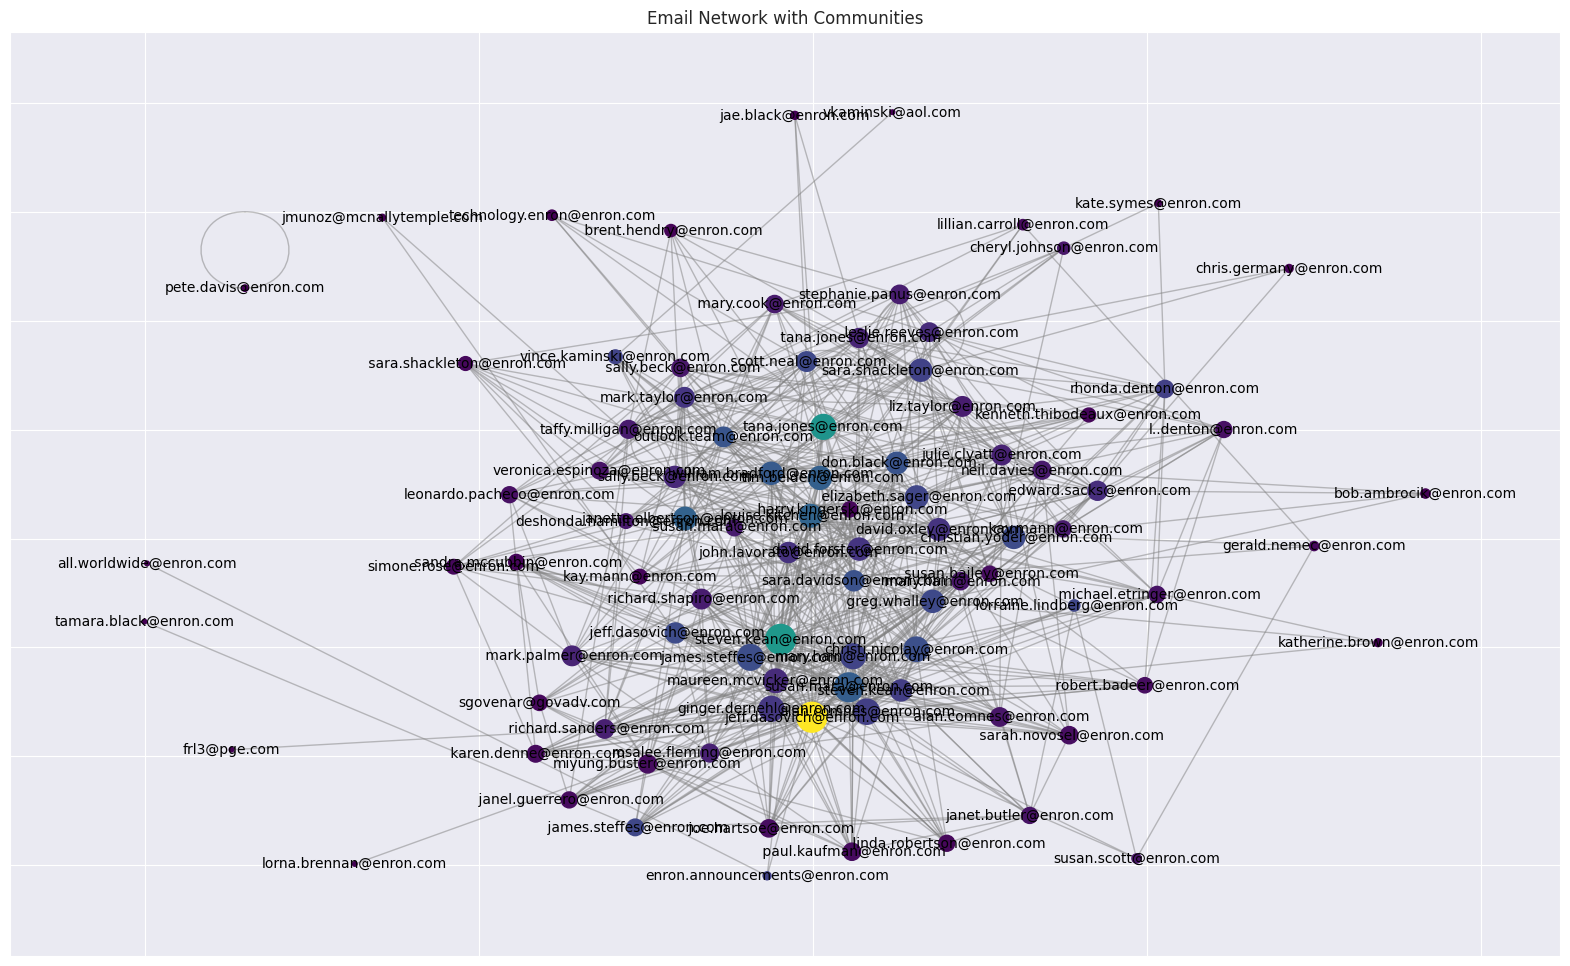

In [ ]:
# Degree Centrality Analysis
degree_centrality = nx.degree_centrality(G)
max_degree_node = max(degree_centrality, key=degree_centrality.get)
min_degree_node = min(degree_centrality, key=degree_centrality.get)
average_degree = sum(degree_centrality.values()) / len(degree_centrality)

print("Degree Centrality Analysis:")
print(f"Maximum Degree Node: {max_degree_node} (Degree: {degree_centrality[max_degree_node]})")
print(f"Minimum Degree Node: {min_degree_node} (Degree: {degree_centrality[min_degree_node]})")
print(f"Average Degree: {average_degree}")

# Betweenness Centrality Analysis
betweenness_centrality = nx.betweenness_centrality(G)
max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
min_betweenness_node = min(betweenness_centrality, key=betweenness_centrality.get)
average_betweenness = sum(betweenness_centrality.values()) / len(betweenness_centrality)

print("\nBetweenness Centrality Analysis:")
print(f"Maximum Betweenness Node: {max_betweenness_node} (Betweenness: {betweenness_centrality[max_betweenness_node]})")
print(f"Minimum Betweenness Node: {min_betweenness_node} (Betweenness: {betweenness_centrality[min_betweenness_node]})")
print(f"Average Betweenness: {average_betweenness}")

# Eigenvector Centrality Analysis
eigenvector_centrality = nx.eigenvector_centrality(G)
max_eigenvector_node = max(eigenvector_centrality, key=eigenvector_centrality.get)
min_eigenvector_node = min(eigenvector_centrality, key=eigenvector_centrality.get)
average_eigenvector = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)

print("\nEigen Vector Centrality Analysis:")
print(f"Maximum Eigenvector Node: {max_eigenvector_node} (Eigenvector: {eigenvector_centrality[max_eigenvector_node]})")
print(f"Minimum Eigenvector Node: {min_eigenvector_node} (Eigenvector: {eigenvector_centrality[min_eigenvector_node]})")
print(f"Average Eigenvector: {average_eigenvector}")

# Community Analysis
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

num_communities = len(communities)
largest_community = max(communities.values(), key=len)
average_community_size = sum(len(community) for community in communities.values()) / num_communities

print("\nCommunity Analysis:")
print(f"Number of Communities: {num_communities}")
print(f"Largest Community Size: {len(largest_community)}")
print(f"Average Community Size: {average_community_size}")

# Plotting the Graph
plt.figure(figsize=(20, 12))
nx.draw_networkx_nodes(G, pos, node_size=node_size, cmap=plt.cm.viridis, node_color=node_color, label=True)
nx.draw_networkx_edges(G, pos, alpha=0.5,edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Email Network with Communities")
plt.show()

In [ ]:
# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G_filtered)

# To identify the number of emails sent from out side the organization

In [ ]:
def clean_emails(email_str):
    cleaned_emails = email_str.split("{")[1].split("}")[0].replace("'", "").split(", ")
    return ', '.join(cleaned_emails)

In [ ]:
filtered_df = df[(df['Date'].dt.year==1999)]

In [ ]:
filtered_df.head(2)

Message-ID                Date  \
275  <20615179.1075855692774.JavaMail.evans@thyme> 1999-12-11 14:39:00   
276  <29805840.1075855692795.JavaMail.evans@thyme> 1999-12-10 15:00:00   

                                       From  \
275  frozenset({'phillip.allen@enron.com'})   
276  frozenset({'phillip.allen@enron.com'})   

                                          To                         Subject  \
275      frozenset({'pallen70@hotmail.com'})  Stick it in your Shockmachine!   
276  frozenset({'naomi.johnston@enron.com'})                             NaN   

     Mime-Version                  Content-Type Content-Transfer-Encoding  \
275           1.0  text/plain; charset=us-ascii                      7bit   
276           1.0  text/plain; charset=us-ascii                      7bit   

    X-cc X-bcc                                         X-Folder X-Origin  \
275  NaN   NaN  \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   
276  NaN   NaN  \Phillip_Allen_Dec2000\Notes Folders\'sent mail  Allen-P   

     X-FileName                                            content     user  \
275  pallen.nsf  ---------------------- Forwarded by Phillip K ...  allen-p   
276  pallen.nsf  Naomi,\n\nThe two analysts that I have had con...  allen-p   

     has_forwarded_content  Year Date_yyyy_mm_dd  
275                   True  1999      1999-12-11  
276                  False  1999      1999-12-10

In [ ]:
filtered_df['From'] = filtered_df['From'].apply(clean_emails)

<ipython-input-175-d04f44f618bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['From'] = filtered_df['From'].apply(clean_emails)


In [ ]:
def extract_domain(email):
    return email.split('@')[-1]

# Apply the function to create a new column
filtered_df['Domain'] = filtered_df['From'].apply(extract_domain)

<ipython-input-176-20077a45b782>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Domain'] = filtered_df['From'].apply(extract_domain)


In [ ]:
new_df = filtered_df[filtered_df['Domain'] != "enron.com"]

In [ ]:
new_df = new_df.groupby('Domain')

In [ ]:
domain_counts = new_df.size()

In [ ]:
print(domain_counts)

Domain
abacustech.net      3
acex.com            2
aec.ca              2
aiglincoln.com      2
amazon.com          7
                   ..
us.oracle.com       2
velaw.com           2
webvangroup.com     2
worldnet.att.net    3
yahoo.com           2
Length: 115, dtype: int64


In [ ]:
# Sort the groups based on their sizes in decreasing order
sorted_domains = domain_counts.sort_values(ascending=False)

# Get the top 10 domains along with their counts
top_10_domains = sorted_domains.head(30)

print(top_10_domains)

Domain
haas.berkeley.edu          158
hotmail.com                126
columbiaenergygroup.com    126
earthlink.net               35
sullcrom.com                25
ankarcapital.com            18
aol.com                     18
ect.enron.com               18
doubleclick.net             17
fairisaac.com               16
pge.com                     15
robertmondavi.com           14
marval.com.ar               12
gmssr.com                   12
txu.com                      9
compuserve.com               9
sempra.com                   8
cliffordchance.com           8
tozzini.com.br               8
calpine.com                  7
amazon.com                   7
djinteractive.com            7
interx.net                   6
cpuc.ca.gov                  6
email.msn.com                6
lplpi.com                    6
mail.rfweston.com            6
tfts.tozzini.com.br          6
att.net                      6
juno.com                     6
dtype: int64


# identifying key words in content of email

In [ ]:
pip install rake-nltk

In [ ]:
def clean_emails(email_str):
    cleaned_emails = email_str.split("{")[1].split("}")[0].replace("'", "").split(", ")
    return ', '.join(cleaned_emails)

In [ ]:
import pandas as pd
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from rake_nltk import Rake
import gensim
from gensim import corpora
from pprint import pprint

# Load the email dataset
#df = pd.read_csv("email_dataset.csv")
df.dropna(subset=['Subject'], inplace=True)
df = df.reset_index()
# Identify top sender(s)
df['From'] = df['From'].apply(clean_emails)
top_senders = df['From'].value_counts().index.tolist()
top_sender = top_senders[0]  # Select the top sender

# Filter emails sent by the top sender
top_sender_emails_df = df[df['From'] == top_sender]

# Concatenate email subjects and content
emails_content = top_sender_emails_df['Subject'] + " " + top_sender_emails_df['content']

# Tokenize the emails
tokenizer = RegexpTokenizer(r'\w+')
tokens = [tokenizer.tokenize(email.lower()) for email in emails_content]

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [[word for word in token if word not in stop_words] for token in tokens]

# Calculate sentiment
sentiments = [TextBlob(email).sentiment.polarity for email in emails_content]

# Keyword extraction
r = Rake()
keywords = []
for email in emails_content:
    r.extract_keywords_from_text(email)
    keywords.append(r.get_ranked_phrases())

# Topic modeling
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
topics = lda_model.print_topics(num_words=5)

# Display results
print(f"Top Sender: {top_sender}")
print("\nSentiment Analysis:")
for i, sentiment in enumerate(sentiments):
    print(f"Email {i+1} Sentiment: {sentiment}")

print("\nKeywords:")
for i, keyword_list in enumerate(keywords):
    print(f"Email {i+1} Keywords: {keyword_list[:5]}")

print("\nTopics:")
pprint(topics)

Streaming output truncated to the last 5000 lines.
Email 5808 Keywords: ['master sales jerry fox reports', 'master sales ---------------------- forwarded', 'peoples data responses seem', 'icc staff may oppose', 'master sales proposal']
Email 5809 Keywords: ['8365 david davis 16415 jacinto port blvd', '2707 north loop west houston', 'abb facility agreement attached', 'abb facility agreement', 'abb facility agreement']
Email 5810 Keywords: ['pastoria turbine contract trains 1', 'final ). doc thank', 'kay', '2']
Email 5811 Keywords: ['suzanne adams', 'sounds good', 'kay mann', 'good day', 'enron cc']
Email 5812 Keywords: ['prototype letter agreement << 2rz503 !. doc >> << 2rz5red', '2 129569v3 r 128541v18 confidentiality notice', 'master 7ea facility agreement rather', 'doc >> << 2r6lred', '2rz503 !. doc']
Email 5813 Keywords: ['lisa ----- original message -----', '----- original message -----', 'get ca ii lined', 'doc >> << file', 'doc >> << file']
Email 5814 Keywords: ['got 10 docs goin

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
emails_content

9506      Re: FW: Prepay to Reliant We are in a loop.  W...
9863      ISDA's with Enron MW I'm looking for ISDA's be...
9896      Midland Cogeneration Venture termination Could...
128159        Dominion letter Here's a revised letter:\n\n 
128162    RE: Dominion We can work with it either way. \...
                                ...                        
422812    Re: Midwest Energy Hub LLC ("Midwest") Feels f...
422815    Re: Midwest Energy Hub LLC ("Midwest") Sara,\n...
425509    ISDA documents Gregg,\n\nIt is my understandin...
450321    Nanny Hi Carol,\n\nI saw that you posted about...
451784    Nanny Hi Carol,\n\nI saw that you posted about...
Length: 16735, dtype: object

In [ ]:
!pip install transformers

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

# Sentiment Analysis 2

In [ ]:
filtered_df = df.loc[(df['Date'].dt.strftime(
    '%Y-%m-%d').between('2001-12-01', '2001-12-31')) & (df['From'] == 'pete.davis@enron.com')]

In [ ]:
#filtered_df = df.loc[(df['Date'].dt.strftime('%Y-%m-%d').between('2001-10-15', '2001-10-16'))]
filtered_df['Date'].value_counts()

Date
2001-12-14 22:33:59    1
2001-12-15 20:38:15    1
2001-12-15 22:38:13    1
2001-12-15 23:38:13    1
2001-12-16 00:38:16    1
                      ..
2001-12-23 06:56:33    1
2001-12-23 07:36:53    1
2001-12-23 08:56:32    1
2001-12-23 09:37:01    1
2001-12-29 18:38:00    1
Name: count, Length: 491, dtype: int64

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 491 entries, 363893 to 511782
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Message-ID                 491 non-null    object        
 1   Date                       491 non-null    datetime64[ns]
 2   From                       491 non-null    object        
 3   To                         491 non-null    object        
 4   Subject                    491 non-null    object        
 5   Mime-Version               491 non-null    float64       
 6   Content-Type               491 non-null    object        
 7   Content-Transfer-Encoding  491 non-null    object        
 8   X-cc                       490 non-null    object        
 9   X-bcc                      0 non-null      object        
 10  X-Folder                   491 non-null    object        
 11  X-Origin                   491 non-null    object        
 12  X-Fil

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
import email
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def clean_column(data):
    if data is not None:
        stopwords_list = stopwords.words('english')
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
        data =  data.lower()
        data = re.sub('re:', '', data)
        data = re.sub('-', '', data)
        data = re.sub('_', '', data)
        # Remove data between square brackets
        data =re.sub('\[[^]]*\]', '', data)
        # removes punctuation
        data = re.sub(r'[^\w\s]','',data)
        data = re.sub(r'\n',' ',data)
        data = re.sub(r'[0-9]+','',data)
        # strip html
        p = re.compile(r'<.*?>')
        data = re.sub(r"\'ve", " have ", data)
        data = re.sub(r"can't", "cannot ", data)
        data = re.sub(r"n't", " not ", data)
        data = re.sub(r"I'm", "I am", data)
        data = re.sub(r" m ", " am ", data)
        data = re.sub(r"\'re", " are ", data)
        data = re.sub(r"\'d", " would ", data)
        data = re.sub(r"\'ll", " will ", data)
        data = re.sub('forwarded by phillip k allenhouect on    pm', '',data)
        data = re.sub(r"httpitcappscorpenroncomsrrsauthemaillinkaspidpage", "", data)

        data = p.sub('', data)
        if 'forwarded by:' in data:
            data = data.split('subject')[1]
        data = data.strip()
        return data
    return 'No Subject'


#df['Subject_new'] = df['Subject'].apply(clean_column)
filtered_df['body_new'] = filtered_df['content'].apply(clean_column)

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = filtered_df['body_new'].apply(tokenizer.tokenize)
words_descriptions.head()

363893    [start, date, dayahead, market, no, ancillary,...
363906    [start, date, dayahead, market, no, ancillary,...
363907    [start, date, dayahead, market, dayahead, sche...
363912    [start, date, dayahead, market, dayahead, sche...
510388    [start, date, hourahead, hour, no, ancillary, ...
Name: body_new, dtype: object

In [ ]:
all_words = [word for tokens in words_descriptions for word in tokens]
filtered_df['description_lengths']= [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

14336 words total, with a vocabulary size of 143


<ipython-input-244-87cedc9a1935>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)

[('no', 838),
 ('final', 749),
 ('schedule', 577),
 ('hourahead', 545),
 ('hour', 517),
 ('start', 490),
 ('date', 490),
 ('variances', 451),
 ('detected', 451),
 ('log', 432),
 ('messages', 432),
 ('file', 431),
 ('oportlandwestdeskcalifornia', 431),
 ('schedulingiso', 431),
 ('schedulestxt', 431),
 ('ancillary', 429),
 ('schedules', 429),
 ('awarded', 429),
 ('parsing', 429),
 ('preferred', 247),
 ('a', 221),
 ('the', 193),
 ('to', 192),
 ('cannot', 191),
 ('locate', 191),
 ('or', 191),
 ('revisedpreferred', 191),
 ('that', 191),
 ('matches', 191),
 ('individual', 191),
 ('interchange', 191),
 ('unable', 191),
 ('assign', 191),
 ('deal', 191),
 ('number', 191),
 ('scid', 72),
 ('transtype', 71),
 ('mkttype', 71),
 ('transdate', 71),
 ('in', 68),
 ('download', 61),
 ('failed', 61),
 ('manual', 61),
 ('intervention', 61),
 ('required', 61),
 ('found', 56),
 ('details', 56),
 ('tiepoint', 50),
 ('interchgid', 50),
 ('enrjciso', 50),
 ('engytype', 50),
 ('for', 42),
 ('not', 40),
 ('user

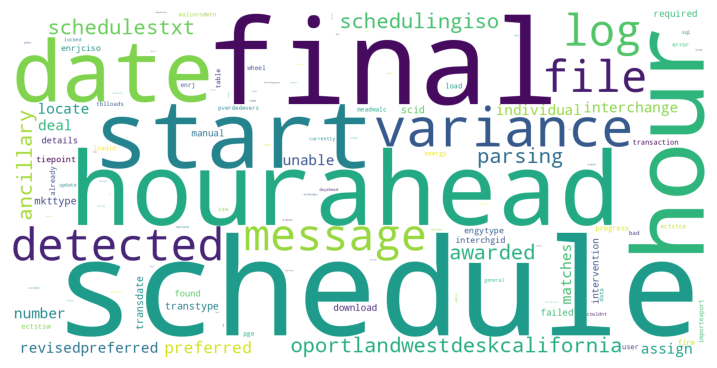

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)

#Visualise Email Subject

wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40,
                          random_state=42
                         ).generate(' '.join(filtered_df['body_new'])) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
filtered_df['scores'] = filtered_df['body_new'].apply(lambda review: analyser.polarity_scores(review))
filtered_df.head()

<ipython-input-247-3a0dd2f2d831>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Message-ID                Date  \
363893    <395925.1075841418474.JavaMail.evans@thyme> 2001-12-14 22:33:59   
363906  <32581988.1075841418810.JavaMail.evans@thyme> 2001-12-13 22:33:15   
363907  <30701227.1075841418834.JavaMail.evans@thyme> 2001-12-13 21:30:59   
363912   <5739678.1075841418937.JavaMail.evans@thyme> 2001-12-12 23:02:44   
510388  <20348456.1075839979614.JavaMail.evans@thyme> 2001-12-29 17:37:49   

                        From                    To  \
363893  pete.davis@enron.com  pete.davis@enron.com   
363906  pete.davis@enron.com  pete.davis@enron.com   
363907  pete.davis@enron.com  pete.davis@enron.com   
363912  pete.davis@enron.com  pete.davis@enron.com   
510388  pete.davis@enron.com  pete.davis@enron.com   

                                         Subject  Mime-Version  \
363893    Start Date: 12/15/01; DayAhead market;           1.0   
363906    Start Date: 12/14/01; DayAhead market;           1.0   
363907        Schedule Crawler: DayAhead Failure           1.0   
363912        Schedule Crawler: DayAhead Failure           1.0   
510388  Start Date: 12/29/01; HourAhead hour: 8;           1.0   

                        Content-Type Content-Transfer-Encoding  \
363893  text/plain; charset=us-ascii                      7bit   
363906  text/plain; charset=us-ascii                      7bit   
363907  text/plain; charset=us-ascii                      7bit   
363912  text/plain; charset=us-ascii                      7bit   
510388  text/plain; charset=us-ascii                      7bit   

                                                     X-cc X-bcc  ...  \
363893  cmallor@enron.com, Davis, Pete </O=ENRON/OU=NA...   NaN  ...   
363906  cmallor@enron.com, Davis, Pete </O=ENRON/OU=NA...   NaN  ...   
363907  cmallor@enron.com, Davis, Pete </O=ENRON/OU=NA...   NaN  ...   
363912  cmallor@enron.com, Davis, Pete </O=ENRON/OU=NA...   NaN  ...   
510388  Meyers, Albert </O=ENRON/OU=NA/CN=RECIPIENTS/C...   NaN  ...   

           X-Origin                   X-FileName  \
363893    PLATTER-P  phillip platter 6-26-02.PST   
363906    PLATTER-P  phillip platter 6-26-02.PST   
363907    PLATTER-P  phillip platter 6-26-02.PST   
363912    PLATTER-P  phillip platter 6-26-02.PST   
510388  WILLIAMS-W3                          NaN   

                                                  content         user  \
363893  \n\nStart Date: 12/15/01; DayAhead market;  No...    platter-p   
363906  \n\nStart Date: 12/14/01; DayAhead market;  No...    platter-p   
363907  \n\nStart Date: 12/14/01; DayAhead market;  Da...    platter-p   
363912  \n\nStart Date: 12/13/01; DayAhead market;  Da...    platter-p   
510388  \n\nStart Date: 12/29/01; HourAhead hour: 8;  ...  williams-w3   

       has_forwarded_content  Year  Date_yyyy_mm_dd  \
363893                 False  2001       2001-12-14   
363906                 False  2001       2001-12-13   
363907                 False  2001       2001-12-13   
363912                 False  2001       2001-12-12   
510388                 False  2001       2001-12-29   

                                                 body_new description_lengths  \
363893  start date  dayahead market  no ancillary sche...                  72   
363906  start date  dayahead market  no ancillary sche...                  19   
363907  start date  dayahead market  dayahead schedule...                  17   
363912  start date  dayahead market  dayahead schedule...                  17   
510388  start date  hourahead hour   no ancillary sche...                  95   

                                                   scores  
363893  {'neg': 0.029, 'neu': 0.882, 'pos': 0.089, 'co...  
363906  {'neg': 0.19, 'neu': 0.693, 'pos': 0.117, 'com...  
363907  {'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...  
363912  {'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...  
510388  {'neg': 0.044, 'neu': 0.877, 'pos': 0.079, 'co...  

[5 rows x 21 columns]

In [ ]:
filtered_df['compound']  = filtered_df['scores'].apply(lambda score_dict: score_dict['compound'])


<ipython-input-248-663ce21ae887>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
def Sentimnt(x):
    if x>= 0.05:
        return "Positive"
    elif x<= -0.05:
        return "Negative"
    else:
        return "Neutral"
#df['Sentiment'] = df['compound'].apply(lambda c: 'positive' if c >=0.00  else 'negative')
filtered_df['Sentiment'] = filtered_df['compound'].apply(Sentimnt)


filtered_df.head()

<ipython-input-249-99aa0d966deb>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Message-ID                Date  \
363893    <395925.1075841418474.JavaMail.evans@thyme> 2001-12-14 22:33:59   
363906  <32581988.1075841418810.JavaMail.evans@thyme> 2001-12-13 22:33:15   
363907  <30701227.1075841418834.JavaMail.evans@thyme> 2001-12-13 21:30:59   
363912   <5739678.1075841418937.JavaMail.evans@thyme> 2001-12-12 23:02:44   
510388  <20348456.1075839979614.JavaMail.evans@thyme> 2001-12-29 17:37:49   

                        From                    To  \
363893  pete.davis@enron.com  pete.davis@enron.com   
363906  pete.davis@enron.com  pete.davis@enron.com   
363907  pete.davis@enron.com  pete.davis@enron.com   
363912  pete.davis@enron.com  pete.davis@enron.com   
510388  pete.davis@enron.com  pete.davis@enron.com   

                                         Subject  Mime-Version  \
363893    Start Date: 12/15/01; DayAhead market;           1.0   
363906    Start Date: 12/14/01; DayAhead market;           1.0   
363907        Schedule Crawler: DayAhead Failure           1.0   
363912        Schedule Crawler: DayAhead Failure           1.0   
510388  Start Date: 12/29/01; HourAhead hour: 8;           1.0   

                        Content-Type Content-Transfer-Encoding  \
363893  text/plain; charset=us-ascii                      7bit   
363906  text/plain; charset=us-ascii                      7bit   
363907  text/plain; charset=us-ascii                      7bit   
363912  text/plain; charset=us-ascii                      7bit   
510388  text/plain; charset=us-ascii                      7bit   

                                                     X-cc X-bcc  ...  \
363893  cmallor@enron.com, Davis, Pete </O=ENRON/OU=NA...   NaN  ...   
363906  cmallor@enron.com, Davis, Pete </O=ENRON/OU=NA...   NaN  ...   
363907  cmallor@enron.com, Davis, Pete </O=ENRON/OU=NA...   NaN  ...   
363912  cmallor@enron.com, Davis, Pete </O=ENRON/OU=NA...   NaN  ...   
510388  Meyers, Albert </O=ENRON/OU=NA/CN=RECIPIENTS/C...   NaN  ...   

                                                  content         user  \
363893  \n\nStart Date: 12/15/01; DayAhead market;  No...    platter-p   
363906  \n\nStart Date: 12/14/01; DayAhead market;  No...    platter-p   
363907  \n\nStart Date: 12/14/01; DayAhead market;  Da...    platter-p   
363912  \n\nStart Date: 12/13/01; DayAhead market;  Da...    platter-p   
510388  \n\nStart Date: 12/29/01; HourAhead hour: 8;  ...  williams-w3   

       has_forwarded_content  Year Date_yyyy_mm_dd  \
363893                 False  2001      2001-12-14   
363906                 False  2001      2001-12-13   
363907                 False  2001      2001-12-13   
363912                 False  2001      2001-12-12   
510388                 False  2001      2001-12-29   

                                                 body_new  \
363893  start date  dayahead market  no ancillary sche...   
363906  start date  dayahead market  no ancillary sche...   
363907  start date  dayahead market  dayahead schedule...   
363912  start date  dayahead market  dayahead schedule...   
510388  start date  hourahead hour   no ancillary sche...   

        description_lengths  \
363893                   72   
363906                   19   
363907                   17   
363912                   17   
510388                   95   

                                                   scores compound  Sentiment  
363893  {'neg': 0.029, 'neu': 0.882, 'pos': 0.089, 'co...   0.5719   Positive  
363906  {'neg': 0.19, 'neu': 0.693, 'pos': 0.117, 'com...  -0.1779   Negative  
363907  {'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...  -0.7184   Negative  
363912  {'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...  -0.7184   Negative  
510388  {'neg': 0.044, 'neu': 0.877, 'pos': 0.079, 'co...   0.1280   Positive  

[5 rows x 23 columns]

In [ ]:
var1 = filtered_df.groupby('Sentiment').count()['body_new'].reset_index().sort_values(by='body_new',ascending=False)
fig = go.Figure(go.Funnelarea(
    text =var1.Sentiment,
    values = var1.body_new,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

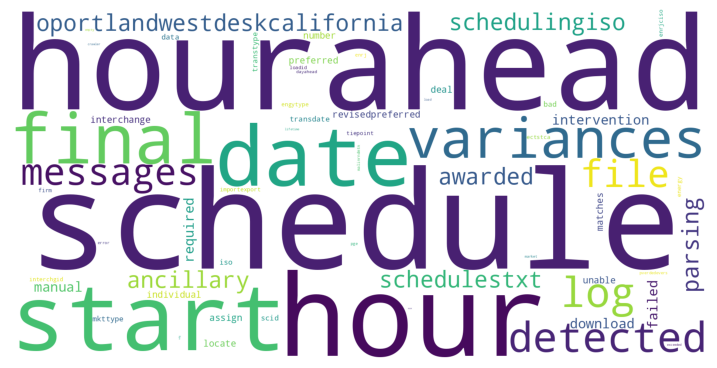

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm']

for i in to_add:
    stopwords.add(i)

#Visualise Email Subject
df5 = filtered_df[filtered_df['Sentiment']=='Negative']
wordcloud = WordCloud(
                          collocations = False,
                          width=1600, height=800,
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          #max_font_size=40,
                          random_state=42
                         ).generate(' '.join(df5['body_new'])) # can't pass a series, needs to be strings and function computes frequencies
print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Message-ID                 517401 non-null  object        
 1   Date                       517401 non-null  datetime64[ns]
 2   From                       517401 non-null  object        
 3   To                         495554 non-null  object        
 4   Subject                    498214 non-null  object        
 5   Mime-Version               517372 non-null  float64       
 6   Content-Type               517372 non-null  object        
 7   Content-Transfer-Encoding  517372 non-null  object        
 8   X-cc                       128886 non-null  object        
 9   X-bcc                      175 non-null     object        
 10  X-Folder                   517372 non-null  object        
 11  X-Origin                   517372 non-null  object  

# EDA

<ipython-input-26-e46a3e5a60ee>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=content_type.index, y=content_type.values, alpha=0.8,palette=colors)


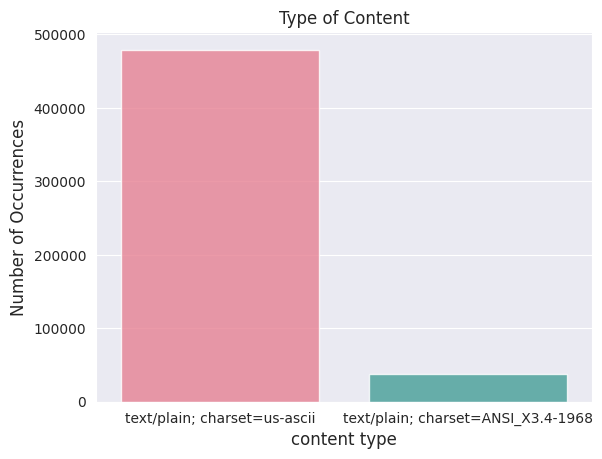

In [ ]:
content_type = df['Content-Type'].value_counts()
colors = sns.color_palette("husl", len(content_type))
sns.barplot(x=content_type.index, y=content_type.values, alpha=0.8,palette=colors)
plt.title('Type of Content')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('content type', fontsize=12)
plt.show()

<ipython-input-43-cf47a847576e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=origin.index, y=origin.values, alpha=0.8, palette=colors)


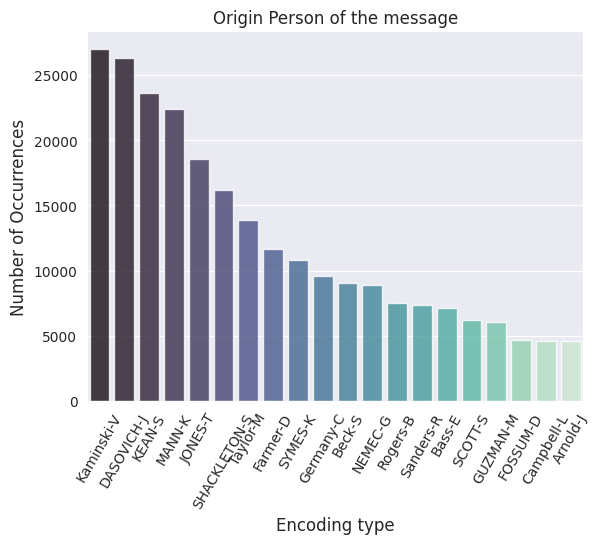

In [ ]:
origin = df['X-Origin'].value_counts()[:20]
colors = sns.color_palette("mako", len(origin))
sns.barplot(x=origin.index, y=origin.values, alpha=0.8, palette=colors)
plt.title('Origin Person of the message')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Encoding type', fontsize=12)
plt.xticks(rotation=60)
plt.show()

<ipython-input-45-88faa1e50697>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=origin.index, y=origin.values, alpha=0.8, palette=colors)


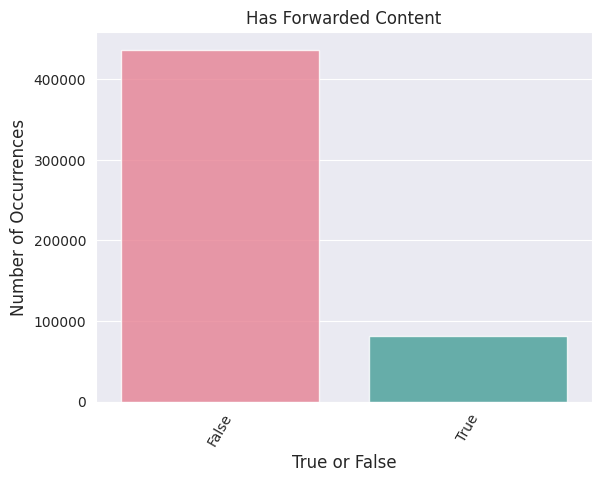

In [ ]:
origin = df['has_forwarded_content'].value_counts()
colors = sns.color_palette("husl", len(origin))
sns.barplot(x=origin.index, y=origin.values, alpha=0.8, palette=colors)
plt.title('Has Forwarded Content')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('True or False', fontsize=12)
plt.xticks(rotation=60)
plt.show()

In [ ]:
filtered_df = df[df['From'] == 'jeff.skilling@enron.com']

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 258838 to 481690
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Message-ID                 108 non-null    object        
 1   Date                       108 non-null    datetime64[ns]
 2   From                       108 non-null    object        
 3   To                         108 non-null    object        
 4   Subject                    107 non-null    object        
 5   Mime-Version               108 non-null    float64       
 6   Content-Type               108 non-null    object        
 7   Content-Transfer-Encoding  108 non-null    object        
 8   X-cc                       19 non-null     object        
 9   X-bcc                      5 non-null      object        
 10  X-Folder                   108 non-null    object        
 11  X-Origin                   108 non-null    object        
 12  X-Fil

# Granger Causality Test

In [ ]:
df_kayy = df[df['From'] == "kay.mann@enron.com"]
df_vince = df[df['From'] == "vince.kaminski@enron.com"]

In [ ]:
df_kayy['Date_yy_mm_dd'] = df_kayy['Date'].dt.date
df_vince['Date_yy_mm_dd'] = df_vince['Date'].dt.date

<ipython-input-27-384c723510d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kayy['Date_yy_mm_dd'] = df_kayy['Date'].dt.date
<ipython-input-27-384c723510d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vince['Date_yy_mm_dd'] = df_vince['Date'].dt.date


In [ ]:
df_kayy.groupby('Date_yy_mm_dd').size()

Date_yy_mm_dd
1980-01-01    38
2000-06-02    52
2000-06-05    26
2000-06-06    40
2000-06-07     3
              ..
2002-03-28     3
2002-04-30     2
2002-05-01     1
2002-05-20     1
2002-05-28     1
Length: 347, dtype: int64

In [ ]:
df_kayy_count_day = df_kayy.groupby('Date_yy_mm_dd').size().to_frame('email_counts')
df_vince_count_day = df_vince.groupby('Date_yy_mm_dd').size().to_frame('email_counts')

In [ ]:
df_kayy_count_day

email_counts
Date_yy_mm_dd              
1980-01-01               38
2000-06-02               52
2000-06-05               26
2000-06-06               40
2000-06-07                3
...                     ...
2002-03-28                3
2002-04-30                2
2002-05-01                1
2002-05-20                1
2002-05-28                1

[347 rows x 1 columns]

In [ ]:
df_vince_count_day

email_counts
Date_yy_mm_dd              
1980-01-01               25
1999-12-10               12
1999-12-14                3
1999-12-15                9
1999-12-16               34
...                     ...
2001-05-05                6
2001-05-07               84
2001-05-08                8
2001-06-08                6
2001-06-20                6

[284 rows x 1 columns]

In [ ]:
df_final = pd.merge(df_kayy_count_day,df_vince_count_day,how='outer',on='Date_yy_mm_dd')

In [ ]:
df_final

email_counts_x  email_counts_y
Date_yy_mm_dd                                
1980-01-01               38.0            25.0
2000-06-02               52.0            28.0
2000-06-05               26.0            31.0
2000-06-06               40.0            31.0
2000-06-07                3.0             NaN
...                       ...             ...
2001-04-28                NaN             7.0
2001-05-05                NaN             6.0
2001-05-07                NaN            84.0
2001-06-08                NaN             6.0
2001-06-20                NaN             6.0

[464 rows x 2 columns]

In [ ]:
df_final.fillna(0,inplace=True)

In [ ]:
df_final.rename(columns={'email_counts_x': 'kay_count', 'email_counts_y': 'vince_count'}, inplace=True)

In [ ]:
df_final['Date_yy_mm_dd'] = df_final.index

In [ ]:
import statsmodels.tsa.stattools
import statsmodels as smt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import operator
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def make_stationary(a):
    #test for stationarity
    p = statsmodels.tsa.stattools.adfuller(a, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[1]
    if p<=0.05:
        print(str(a.name)+' timeseries is stationary')
        return(np.array(a))
    else:
        print(str(a.name)+' timeseries is not stationary. Making it stationary by differentiating:')
        a_new=a
        c=1
        while p>0.05:
            print('Diff step: '+str(c))
            a_new=np.diff(a_new)
            p = statsmodels.tsa.stattools.adfuller(a_new, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[1]
            c+=1
        return(a_new)

def granger(df, maxlag):
    if len(df.columns)!=2:
        raise ValueError("Dataframe has to have two columns")
    x = make_stationary(df.iloc[:,0])
    y = make_stationary(df.iloc[:,1])
    dfx = pd.DataFrame({'x':x})
    dfy = pd.DataFrame({'y':y})
    df = pd.concat([dfx,dfy], ignore_index=True, axis=1)
    s = statsmodels.tsa.stattools.grangercausalitytests(df.iloc[:,[0,1]].dropna(), maxlag=maxlag, addconst=True, verbose=False)
    # print(s)
    valid_delays={}
    p_values = {}
    for key in s.keys():
        # print("*****",key)
        if s[key][0]['params_ftest'][1] <= 0.05:
            # print(s[key][0]['params_ftest'])
            valid_delays[s[key][0]['params_ftest'][3]]=s[key][0]['params_ftest'][0]
            p_values[s[key][0]['params_ftest'][3]] = s[key][0]['params_ftest'][1]
    if len(valid_delays)==0:
        return(0, 0, 1)
    else:
        max_f_test = max(valid_delays.items(), key=operator.itemgetter(1))
        steps = max_f_test[0]
        f_test = max_f_test[1]
        p_value = p_values[steps]
    return(steps, f_test, p_value)

In [ ]:
steps, f_test, p_value = granger(df_final[['kay_count','vince_count']], maxlag=20)
print('~~~Granger Causality Results: ')
print('Lag Steps: '+str(steps))
print('F_test: '+str(f_test))
print('p value: '+str(p_value))

kay_count timeseries is not stationary. Making it stationary by differentiating:
Diff step: 1
vince_count timeseries is stationary
~~~Granger Causality Results: 
Lag Steps: 0
F_test: 0
p value: 1


In [ ]:
steps, f_test, p_value = granger(df_final[['vince_count','kay_count']], maxlag=20)
print('~~~Granger Causality Results: ')
print('Lag Steps: '+str(steps))
print('F_test: '+str(f_test))
print('p value: '+str(p_value))

vince_count timeseries is stationary
kay_count timeseries is not stationary. Making it stationary by differentiating:
Diff step: 1
~~~Granger Causality Results: 
Lag Steps: 3.0
F_test: 3.2658779681643195
p value: 0.021258722924258764


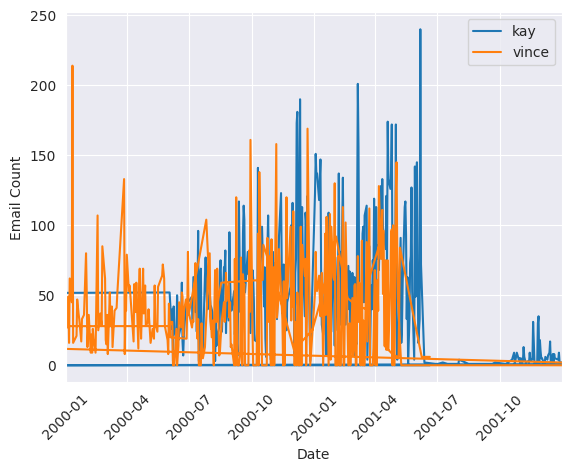

In [ ]:
plt.plot(df_final['kay_count'], label='kay')
plt.plot(df_final['vince_count'], label='vince')
plt.xlabel('Date')
plt.ylabel('Email Count')
plt.xlim(pd.Timestamp('2000-01-01'), pd.Timestamp('2001-12-31'))
plt.xticks(rotation=45)
plt.legend()

In [ ]:
correlation = df_final['kay_count'].corr(df_final['vince_count'])

print(f"The Pearson correlation coefficient between realcons and realgdp is: {correlation}")

The Pearson correlation coefficient between realcons and realgdp is: 0.22054266015046844
